# Vantage Analytic Library & teradataml demo

- Contributions by:
    - Tim Miller, Principal Software Architect, Teradata PM/Advanced Analytics 
    - Ryan Speed, Senior Data Scientist, Teradata PE/Telemetry
    - Alexander Kolovos, Sr Staff Software Architect, Teradata PE/Languages

In [1]:
# Load teradataml and dependency packages

from teradataml import create_context, DataFrame, get_context, copy_to_sql, in_schema, remove_context
from teradataml.dataframe.sql_functions import case
import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import getpass as gp
from sqlalchemy.sql.expression import select, or_, extract, text, join, case as case_when
from sqlalchemy import func

# Import "valib" object from teradataml to execute Vantage Analytic Library functions.
# Set 'configure.val_install_location' to the database name where Vantage analytic library functions are installed.

from teradataml import *
from teradataml.analytics.valib import *
from teradataml import configure
configure.val_install_location = "TRNG_XSP"

from pycaret.utils import enable_colab
enable_colab()

import xml.dom.minidom

import pylab

Colab mode enabled.


In [2]:
%matplotlib inline

# define matplotlib styles for this notebook
plt.style.use('fivethirtyeight')
pylab.rcParams['figure.figsize'] = (20, 6)
pylab.rcParams['font.size'] = 16
pylab.rcParams['text.color'] = 'black'
pylab.rcParams['axes.labelcolor'] = 'black'
pylab.rcParams['xtick.color'] =  'black'
pylab.rcParams['ytick.color'] =  'black'  
pylab.rcParams['ytick.labelsize'] = 'large'

#pylab.rcParams.keys() 

## Connection

In [3]:
# Establish connection to Teradata Vantage server (uses the Teradata SQL Driver
# for Python). Before you execute the following statement, replace the variables
# <HOSTNAME>, <UID> and <PWD> with your target Vantage system hostname (or
# IP address), and your database user ID and password, respectively.

td_context = create_context(host="tdprd.td.teradata.com", username="rb255002", password=gp.getpass(prompt='Password:'), logmech="LDAP")

Password: ··········


# Section 1: Demo Data

### Demo data - Financial Customers/Accounts/Transactions

The following data has been put into the TRNG_XSP database on Transcend for the examples in this Python Jupyter Notebook.  Its a simplistic ficticiouss dataset of banking customers (10K-ish rows), Accounts (100K-ish rows) and Transactions (1M-ish rows).  They are related to each other in the following ways:

![TWMDemoDataModel](img/DemoData.png)

In [4]:
# Create DataFrames for the Customer, Accounts and Transactions tables in the
# Vantage Advanced SQL Engine. 
tdCustomer = DataFrame(in_schema("rb255002", "Customer"))

# Using to_pandas() for a cleaner display format
tdCustomer.to_pandas().head(10)

income  age  years_with_bank  nbr_children gender marital_status  \
cust_id                                                                        
28617834    2553.2   36                6             4      F              4   
21803664       0.0   13                8             1      M              1   
31346907  226701.8   43                3             1      F              3   
25897836    3020.0   51                8             1      F              2   
27258100   23226.0   39                7             2      F              2   
13633310   31054.0   56                6             3      M              2   
19085542   55007.4   59                9             2      F              4   
17716569   20389.2   49                6             4      F              2   
13625520    8005.0   34                4             3      F              3   
31352657   25366.7   46                4             0      M              1   

         postal_code state_code  
cust_id                          
28617834       92804         CA  
21803664       10104         NY  
31346907       60650         IL  
25897836       20126         DC  
27258100       93702         CA  
13633310       55113         MN  
19085542       60666         IL  
17716569       60654         IL  
13625520       92513         CA  
31352657       87129         NM

In [5]:
tdAccounts = DataFrame(in_schema("rb255002", "Accounts"))
# Using to_pandas() for a cleaner display format
tdAccounts.to_pandas().head(10)

cust_id acct_type account_active acct_start_date  \
acct_nbr                                                                
000000001362820221  28619220        CK              Y      1990-05-10   
000000001362557221  28613697        CK              Y      1995-09-08   
000000001362625222  29977750        CK              N      1990-06-29   
456114321363234422  29991148        CC              Y      1995-11-20   
456114321363229416  21811664        CC              Y      1993-06-11   
456114321362852422  29982744        CC              Y      1993-10-28   
456114321362791411  14990701        CC              Y      1994-02-24   
000000001363257321  28628397        SV              Y      1993-09-08   
000000001362758223  31343434        CK              Y      1994-11-03   
000000001362516218  24525288        CK              Y      1995-10-25   

                   starting_balance ending_balance  
acct_nbr                                            
000000001362820221        27093.380      13144.470  
000000001362557221         2166.270        106.060  
000000001362625222          538.153       4851.938  
456114321363234422            0.000      27300.000  
456114321363229416         3067.295       1163.130  
456114321362852422         1785.608      15470.000  
456114321362791411         5919.887        771.358  
000000001363257321          294.210       1168.670  
000000001362758223         2589.510        497.320  
000000001362516218         3820.170       3378.880

In [6]:
tdTransactions = DataFrame(in_schema("rb255002", "Transactions"))
# Using to_pandas() for a cleaner display format
tdTransactions.to_pandas().head(10)

tran_amt principal_amt interest_amt new_balance  \
tran_id acct_nbr                                                             
62      0000000013628302      66.70         66.70        0.000      332.72   
253     000000001363434323     0.00          0.00        0.000     2036.80   
1330    000000001363165214   -29.54         -6.79        0.760      322.87   
920     000000001362592223   309.97        309.97        0.000      599.84   
483     000000001362669323   132.86        132.86        0.000     1979.07   
84      0000000013631832     648.66        648.66        0.000      660.84   
        456114321362720412  -109.05       -245.36        1.000    -1000.00   
714     000000001362995214    35.00          8.05        0.760     2170.74   
156     000000001362484312   102.64        230.94        1.000      791.06   
180     000000001363199320     0.37          0.00        4.370      298.46   

                             tran_date  tran_time channel tran_code  
tran_id acct_nbr                                                     
62      0000000013628302    1995-02-13     110307       B        DP  
253     000000001363434323  1995-01-02     145819       A        IQ  
1330    000000001363165214  1995-03-06          0       P        WD  
920     000000001362592223  1995-03-29     152740       A        DP  
483     000000001362669323  1995-08-14     195309       B        DP  
84      0000000013631832    1995-02-21      92829       B        DP  
        456114321362720412  1995-08-28     103757       E        CG  
714     000000001362995214  1995-09-25          0       M        DP  
156     000000001362484312  1995-05-27     234441       A        DP  
180     000000001363199320  1995-06-30     235959    None        IN

## Values Function:

### SIGNATURE:
> valib.Values(data, columns=None, exclude_columns=None, group_columns=None, distinct=False, filter=None)

### DESCRIPTION:
Use Values analysis as the first type of analysis performed on unknown data. Values analysis determines the nature and quality of the data. For example, whether the data is categorical or continuously numeric, how many null values it contains, and so on. 
A Values analysis provides a count of rows, rows with non-null values, rows with null values, rows with value 0, rows with a positive value, rows with a negative value, and the number of rows containing blanks in the given column. By default, unique values are counted, but this calculation can be inhibited for performance reasons if desired. 
For a column of non-numeric type, the zero, positive, and negative counts are always zero (for example, 000 is not counted as 0). A Values analysis can be performed on columns of any data type, though the measures displayed vary according to column type. 

### PARAMETERS:

#### data:
Required Argument.
Specifies the input data to perform Values analysis.
Types: teradataml DataFrame

#### columns:
Required Argument.
Specifies the name(s) of the column(s) to analyze. Occasionally, it can also accept permitted strings to specify all columns, or all numeric columns, or all character columns.
Permitted Values:
- Name(s) of the column(s) in "data".
- Pre-defined strings: 
    - 'all' – all columns
    - 'allnumeric' – all numeric columns
    - 'allcharacter' - all numeric and date columns

Types: str OR list of Strings (str)

#### exclude_columns:
Optional Argument.
Specifies the name(s) of the column(s) to exclude from the analysis, if a column specifier such as 'all', 'allnumeric', 'allcharacter' is used in the "columns" argument.

Types: str OR list of Strings (str)

#### group_columns:
Optional Argument.
Specifies the name(s) of column(s) to perform separate analysis for each group.

Types: str OR list of Strings (str)

#### distinct:
Optional Argument.
Specifies whether to select unique values count for each selected column.
Default Value: False

Types: bool

#### filter:
Optional Argument.
Specifies the clause to filter rows selected for analysis within Values.
For example,
    filter = "cust_id > 0"

Types: str

### RETURNS:
An instance of Values.
Output teradataml DataFrames can be accessed using attribute references, such as ValuesObj.<attribute_name>.
Output teradataml DataFrame attribute name is: result.

### RAISES:
TeradataMlException, TypeError, ValueError

In [7]:
# Example 1: Perform Values analysis using default values on 'income' and 'marital_status' columns.
tdCustomer_val1 = valib.Values(data=tdCustomer, columns=["all"])
# Print the results
# Using to_pandas() for a cleaner display format
tdCustomer_val1.result.to_pandas().head(10)

xtype     xcnt  \
xdb      xtbl     xcol                                                       
rb255002 Customer marital_status   VARCHAR(1) CHARACTER SET LATIN  10458.0   
                  income                            DECIMAL(15,1)  10458.0   
                  nbr_children                            INTEGER  10458.0   
                  cust_id                                 INTEGER  10458.0   
                  age                                     INTEGER  10458.0   
                  years_with_bank                         INTEGER  10458.0   
                  postal_code      VARCHAR(5) CHARACTER SET LATIN  10458.0   
                  gender           VARCHAR(1) CHARACTER SET LATIN  10458.0   
                  state_code       VARCHAR(2) CHARACTER SET LATIN  10458.0   

                                   xnull  xunique  xblank   xzero     xpos  \
xdb      xtbl     xcol                                                       
rb255002 Customer marital_status     0.0      4.0     0.0     NaN      NaN   
                  income             0.0   8253.0     NaN  1428.0   9030.0   
                  nbr_children       0.0      9.0     NaN  2330.0   8128.0   
                  cust_id            0.0  10458.0     NaN     0.0  10458.0   
                  age                0.0     86.0     NaN     0.0  10458.0   
                  years_with_bank    0.0     15.0     NaN   176.0  10282.0   
                  postal_code        0.0    442.0     0.0     NaN      NaN   
                  gender             0.0      2.0     0.0     NaN      NaN   
                  state_code         0.0     33.0     0.0     NaN      NaN   

                                   xneg  
xdb      xtbl     xcol                   
rb255002 Customer marital_status    NaN  
                  income            0.0  
                  nbr_children      0.0  
                  cust_id           0.0  
                  age               0.0  
                  years_with_bank   0.0  
                  postal_code       NaN  
                  gender            NaN  
                  state_code        NaN

### Plots

#### Bar Chart - Unique Values

In [8]:
# Remove Index from Values plots data
tdCustomer_bar_pd = tdCustomer_val1.result.to_pandas().reset_index()

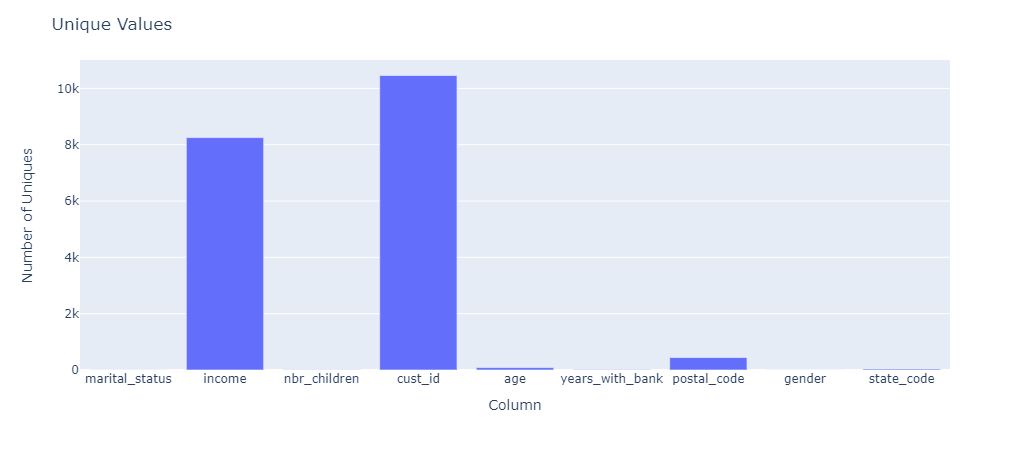

In [10]:
fig = px.bar(tdCustomer_bar_pd, x='xcol', y=["xunique"])
fig.update_layout(height=450, width=1100, title="Unique Values")
fig.update_xaxes(tickangle = 0, title="Column")   
fig.update_yaxes(title="Number of Uniques")   
fig.update_layout(showlegend=False)
fig

#### Stacked Bar Chart - Count, NULL, Unique, Blank, Zero, Positive and Negative Values

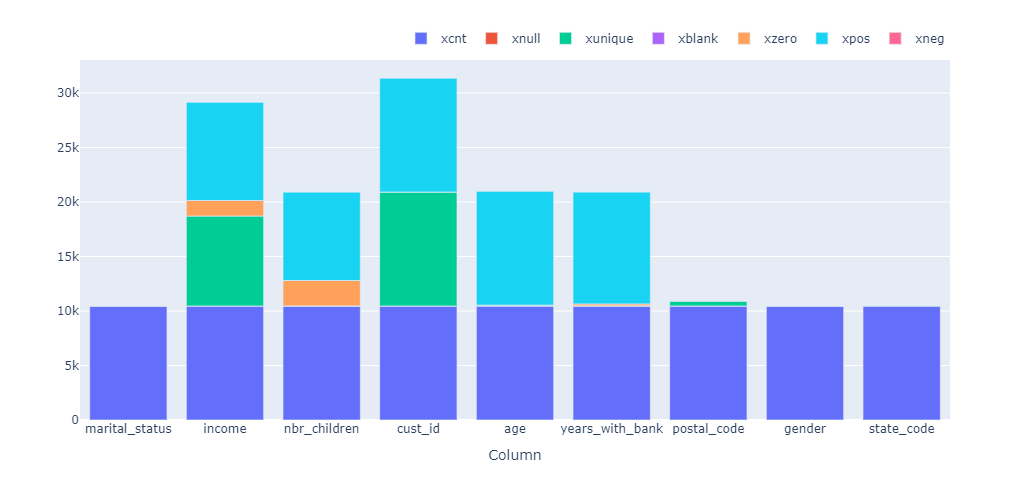

In [11]:
fig = px.bar(tdCustomer_bar_pd, x='xcol', y=["xcnt", "xnull", "xunique","xblank","xzero","xpos","xneg"])
fig.update_layout(height=500, width=1000)
fig.update_xaxes(tickangle = 0, title="Column")   
fig.update_yaxes(title="")   
fig.update_layout(legend=dict(
    title="",
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig.show() 

#### Horizontal Bar Chart - Count, NULL, Unique, Blank, Zero, Positive and Negative Values

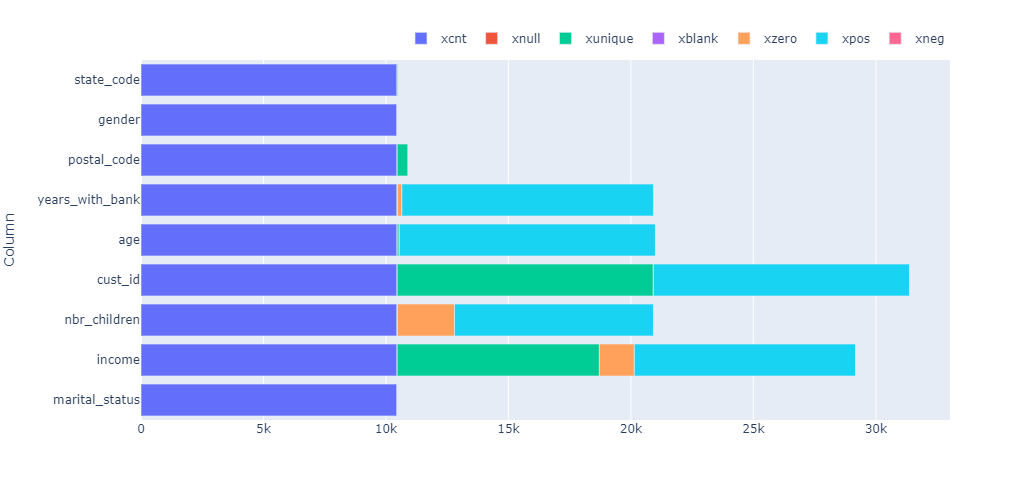

In [12]:
fig = px.bar(tdCustomer_bar_pd, x=["xcnt", "xnull", "xunique","xblank","xzero","xpos","xneg"], y='xcol')
fig.update_layout(height=500)
fig.update_yaxes(title="Column")   
fig.update_xaxes(title="") 
fig.update_layout(legend=dict(
    title="",
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show() 

In [13]:
# Example 2: Perform Values analysis on 'income' column with values grouped by 'gender' and only for rows with income greater than 0.
tdCustomer_val2 = valib.Values(data=tdCustomer, columns=["all"], group_columns="gender", filter="income > 0")
# Print the results
# Using to_pandas() for a cleaner display format
tdCustomer_val2.result.to_pandas().head(20)

xtype  \
gender xdb      xtbl     xcol                                              
F      rb255002 Customer marital_status   VARCHAR(1) CHARACTER SET LATIN   
                         postal_code      VARCHAR(5) CHARACTER SET LATIN   
                         income                            DECIMAL(15,1)   
M      rb255002 Customer cust_id                                 INTEGER   
F      rb255002 Customer nbr_children                            INTEGER   
                         cust_id                                 INTEGER   
                         years_with_bank                         INTEGER   
M      rb255002 Customer state_code       VARCHAR(2) CHARACTER SET LATIN   
                         age                                     INTEGER   
                         years_with_bank                         INTEGER   
                         marital_status   VARCHAR(1) CHARACTER SET LATIN   
                         income                            DECIMAL(15,1)   
F      rb255002 Customer age                                     INTEGER   
M      rb255002 Customer nbr_children                            INTEGER   
F      rb255002 Customer state_code       VARCHAR(2) CHARACTER SET LATIN   
M      rb255002 Customer postal_code      VARCHAR(5) CHARACTER SET LATIN   

                                            xcnt  xnull  xunique  xblank  \
gender xdb      xtbl     xcol                                              
F      rb255002 Customer marital_status   5054.0    0.0      4.0     0.0   
                         postal_code      5054.0    0.0    326.0     0.0   
                         income           5054.0    0.0   4640.0     NaN   
M      rb255002 Customer cust_id          3976.0    0.0   3976.0     NaN   
F      rb255002 Customer nbr_children     5054.0    0.0      9.0     NaN   
                         cust_id          5054.0    0.0   5054.0     NaN   
                         years_with_bank  5054.0    0.0     15.0     NaN   
M      rb255002 Customer state_code       3976.0    0.0     32.0     0.0   
                         age              3976.0    0.0     79.0     NaN   
                         years_with_bank  3976.0    0.0     15.0     NaN   
                         marital_status   3976.0    0.0      4.0     0.0   
                         income           3976.0    0.0   3669.0     NaN   
F      rb255002 Customer age              5054.0    0.0     81.0     NaN   
M      rb255002 Customer nbr_children     3976.0    0.0      9.0     NaN   
F      rb255002 Customer state_code       5054.0    0.0     33.0     0.0   
M      rb255002 Customer postal_code      3976.0    0.0    265.0     0.0   

                                           xzero    xpos  xneg  
gender xdb      xtbl     xcol                                   
F      rb255002 Customer marital_status      NaN     NaN   NaN  
                         postal_code         NaN     NaN   NaN  
                         income              0.0  5054.0   0.0  
M      rb255002 Customer cust_id             0.0  3976.0   0.0  
F      rb255002 Customer nbr_children     1015.0  4039.0   0.0  
                         cust_id             0.0  5054.0   0.0  
                         years_with_bank    92.0  4962.0   0.0  
M      rb255002 Customer state_code          NaN     NaN   NaN  
                         age                 0.0  3976.0   0.0  
                         years_with_bank    60.0  3916.0   0.0  
                         marital_status      NaN     NaN   NaN  
                         income              0.0  3976.0   0.0  
F      rb255002 Customer age                 0.0  5054.0   0.0  
M      rb255002 Customer nbr_children      805.0  3171.0   0.0  
F      rb255002 Customer state_code          NaN     NaN   NaN  
M      rb255002 Customer postal_code         NaN     NaN   NaN

#### 3-D Chart - Unique Values by Gender

In [14]:
def draw_3d_bar(data):
    unique_genders = data.reset_index().gender.unique()
    unique_xcols = data.reset_index()["xcol"].unique()
    x = [[data.at[gender, col] for col in unique_xcols ] for gender in unique_genders]
    result = np.array(x, dtype=np.int)
    fig=plt.figure(figsize=(10, 12), dpi=500)
    ax1=fig.add_subplot(111, projection='3d')    
    xlabels = np.array(unique_xcols)
    xpos = np.arange(xlabels.shape[0])
    ylabels = tdCustomer_bar_pd["gender"].unique()
    ypos = np.arange(ylabels.shape[0])
    xposM, yposM = np.meshgrid(xpos, ypos, copy=False)
    zpos=result
    zpos = zpos.ravel()
    dx=1
    dy=.3
    dz=zpos
    ax1.w_xaxis.set_ticks(xpos )
    ax1.w_xaxis.set_ticklabels(xlabels)
    ax1.w_yaxis.set_ticks(ypos + dy/2.)
    ax1.w_yaxis.set_ticklabels(ylabels)
    values = (dz-dz.min())/np.float_(dz.max()-dz.min())
    colors = cm.rainbow(values)
    ax1.bar3d(xposM.ravel(), yposM.ravel(), dz*0, dx, dy, dz, color=colors)
    plt.title("Unique Values")
    plt.xticks(rotation=70)
    return plt

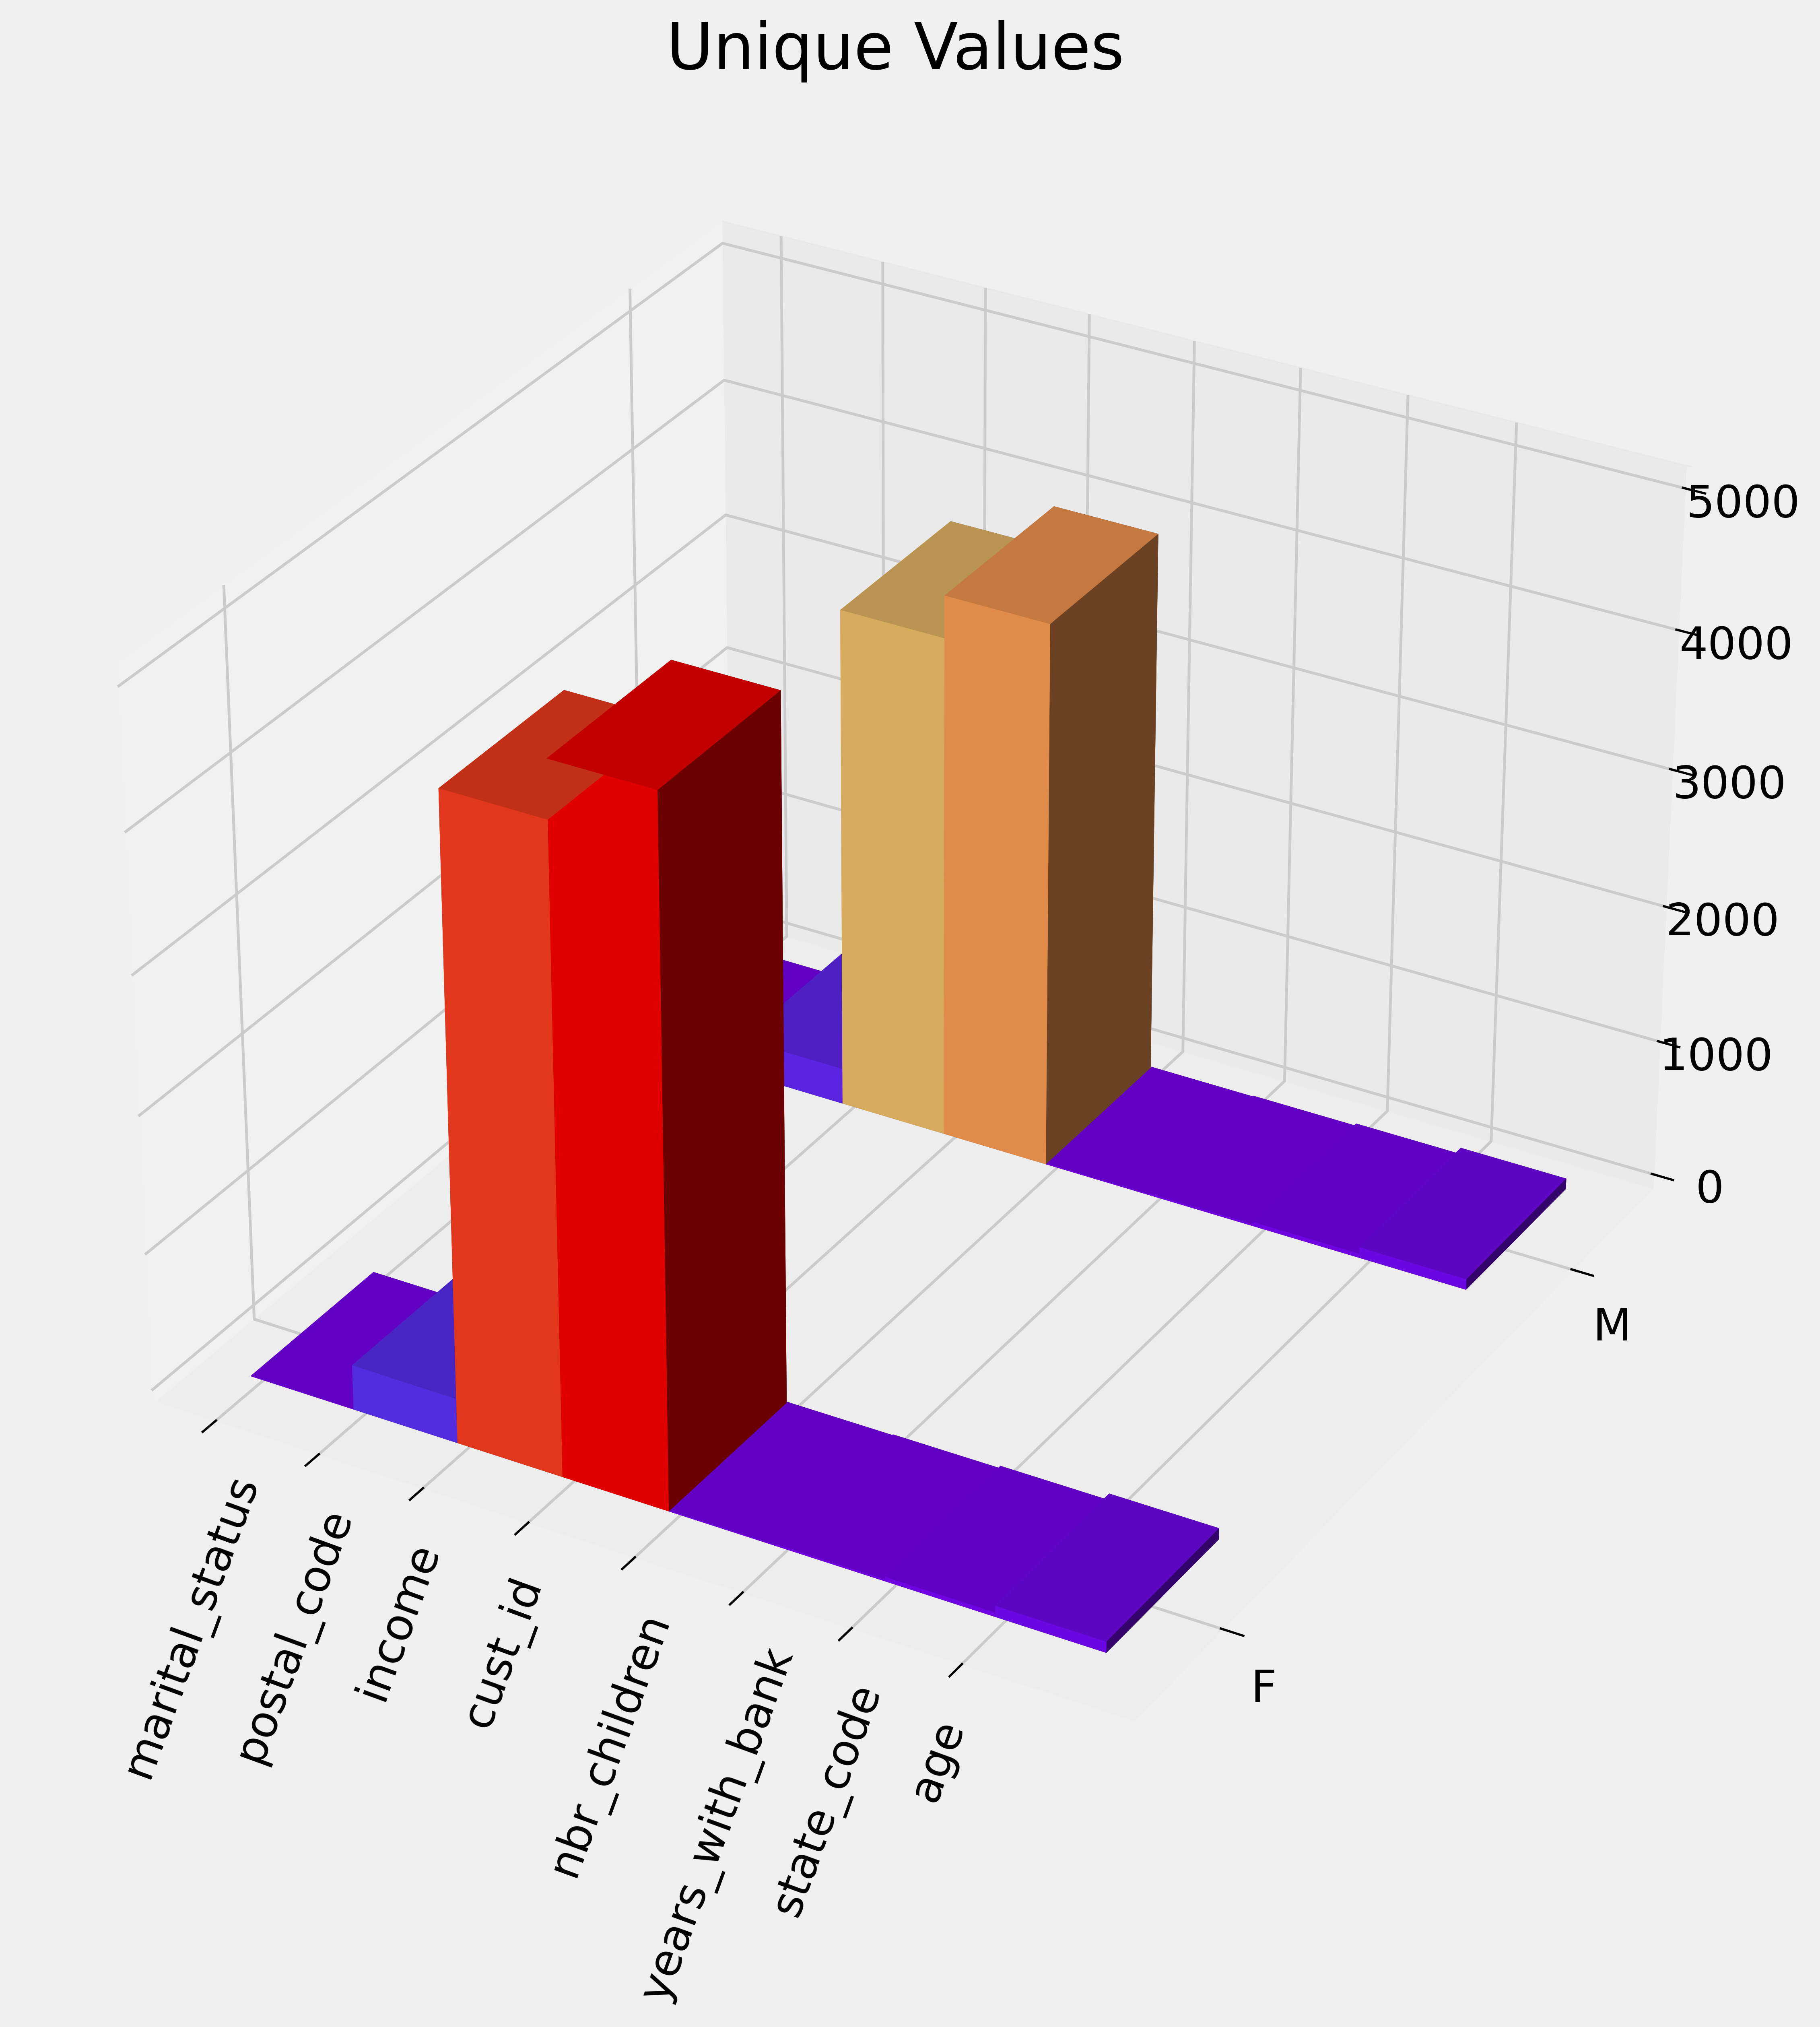

In [15]:
# Remove Index from Values plots data
tdCustomer_bar_pd = tdCustomer_val2.result.to_pandas().reset_index()
data = tdCustomer_val2.result.to_pandas().reset_index().set_index(["gender", "xcol"])["xunique"]
draw_3d_bar(data).show()

## Statistics Function

### SIGNATURE:
> valib.Statistics(data, columns=None, exclude_columns=None, extended_options='none', group_columns=None, statistical_method='population', stats_options=None, filter=None)

### DESCRIPTION:
Statistics analysis provides several common and not so common statistical measures for numeric data columns. Extended options include additional analyses and measures such as Values, Modes, Quantiles, and Ranks. Use statistical measures to understand the characteristics and properties of each numeric column, and to look for outlying values and anomalies.
Statistics analysis can be performed on columns of numeric or date data type. For columns of type DATE, statistics other than count, minimum, maximum, and mean are calculated by first converting to the number of days since 1900.

### PARAMETERS:
data:
Required Argument.
Specifies the input data to perform Statistics analysis.
Types: teradataml DataFrame

#### Columns:
Required Argument.
Specifies the name(s) of the column(s) to analyze. Occasionally, it can also accept permitted strings to specify all columns, or all numeric columns, or all numeric and date columns.
Permitted Values: 
- Name(s) of the column(s) in "data".
- Pre-defined strings: 
    - 'all' – all columns
    - 'allnumeric' – all numeric columns
    - 'allnumericanddate' - all numeric and date columns

Types: str OR list of Strings (str)

#### exclude_columns:
Optional Argument.
Specifies the name(s) of the column(s) to exclude from the analysis, if a column specifier such as 'all', 'allnumeric', 'allnumericanddate' is used in the "columns" argument.

Types: str OR list of Strings (str)

#### extended_options:
Optional Argument.
Specifies the extended options for calculating statistics.
Permitted Values: 
- 'all'
- 'none'
- 'modes'
- 'quantiles'
- 'values'
- 'rank'

Default Value: 'none'

Types: str OR list of Strings (str)

#### group_columns:
Optional Argument.
Specifies the name(s) of column(s) to perform separate analysis for each group.

Types: str OR list of Strings (str)

#### statistical_method:
Optional Argument.
Specifies the statistical method.
Permitted Values: 'sample', 'population'
Default Value: 'population'

Types: str

#### stats_options:
Optional Argument.
Specifies the basic statistics to be calculated.
Permitted Values: 
- all
- count (cnt)
- minimum (min)
- maximum (max)
- mean
- standarddeviation (std)
- skewness (skew)
- kurtosis (kurt)
- standarderror (ste)
- coefficientofvariance (cv)
- variance (var)
- sum
- uncorrectedsumofsquares (uss)
- correctedsumofsquares (css)

Default Value: ['cnt', 'min', 'max', 'mean', 'std']

Types: str OR list of Strings (str)

#### filter:
Optional Argument.
Specifies the clause to filter rows selected for analysis within Statistics.
For example,
    filter = "cust_id > 0"

Types: str

### RETURNS:
An instance of Statistics.
Output teradataml DataFrames can be accessed using attribute references, such as StatisticsObj.<attribute_name>.
Output teradataml DataFrame attribute name is: result.

### RAISES:
TeradataMlException, TypeError, ValueError

In [16]:
# Example 1: First call the Statistics function on all numeric and date columns in the Customer table, taking basic statistics (min/max/mean/std).
tdCustomer_stats1 = valib.Statistics(data=tdCustomer, columns="allnumericanddate")
# Print the results
# Using to_pandas() for a cleaner display format
tdCustomer_stats1.result.to_pandas().head(10)

xcnt        xmin        xmax  \
xdb      xtbl     xcol                                               
rb255002 Customer income           10458.0         0.0    374808.2   
                  nbr_children     10458.0         0.0         8.0   
                  cust_id          10458.0  13624800.0  31360385.0   
                  age              10458.0         9.0        94.0   
                  years_with_bank  10458.0         0.0        14.0   

                                          xmean          xstd  
xdb      xtbl     xcol                                         
rb255002 Customer income           3.006627e+04  3.827622e+04  
                  nbr_children     1.786288e+00  1.462653e+00  
                  cust_id          2.248935e+07  5.494394e+06  
                  age              4.433639e+01  1.926538e+01  
                  years_with_bank  5.764773e+00  2.973770e+00

In [17]:
# Example 2: Next call the Statistics function on the same variables in the Customer table, generating all statistics, including the extended options.
tdCustomer_stats2 = valib.Statistics(data=tdCustomer, columns="allnumericanddate", stats_options="all", extended_options="all")
# Print the results
# Using to_pandas() for a cleaner display format
tdCustomer_stats2.result.to_pandas().head(10)

xcnt        xmin        xmax  \
xdb      xtbl     xcol                                               
rb255002 Customer income           10458.0         0.0    374808.2   
                  nbr_children     10458.0         0.0         8.0   
                  cust_id          10458.0  13624800.0  31360385.0   
                  age              10458.0         9.0        94.0   
                  years_with_bank  10458.0         0.0        14.0   

                                          xmean          xstd     xskew  \
xdb      xtbl     xcol                                                    
rb255002 Customer income           3.006627e+04  3.827622e+04  2.511663   
                  nbr_children     1.786288e+00  1.462653e+00  0.791973   
                  cust_id          2.248935e+07  5.494394e+06  0.000001   
                  age              4.433639e+01  1.926538e+01  0.226521   
                  years_with_bank  5.764773e+00  2.973770e+00  0.203450   

                                      xkurt          xste         xcv  \
xdb      xtbl     xcol                                                  
rb255002 Customer income           9.349902    374.286942  127.306171   
                  nbr_children     0.558117      0.014303   81.882245   
                  cust_id         -1.211969  53727.357792   24.431094   
                  age             -0.755821      0.188388   43.452740   
                  years_with_bank -0.676731      0.029079   51.585210   

                                           xvar  ...      xmax_5      xmax_4  \
xdb      xtbl     xcol                           ...                           
rb255002 Customer income           1.465069e+09  ...    331561.1    332404.8   
                  nbr_children     2.139353e+00  ...         4.0         5.0   
                  cust_id          3.018837e+13  ...  31360293.0  31360316.0   
                  age              3.711548e+02  ...        90.0        91.0   
                  years_with_bank  8.843311e+00  ...        10.0        11.0   

                                       xmax_3      xmax_2      xmax_1  \
xdb      xtbl     xcol                                                  
rb255002 Customer income             335909.6    369912.4    374808.2   
                  nbr_children            6.0         7.0         8.0   
                  cust_id          31360339.0  31360362.0  31360385.0   
                  age                    92.0        93.0        94.0   
                  years_with_bank        12.0        13.0        14.0   

                                   xmaxcnt_5 xmaxcnt_4  xmaxcnt_3  xmaxcnt_2  \
xdb      xtbl     xcol                                                         
rb255002 Customer income                 1.0       1.0        1.0        1.0   
                  nbr_children         751.0     348.0      114.0       49.0   
                  cust_id                1.0       1.0        1.0        1.0   
                  age                   17.0      11.0        6.0       12.0   
                  years_with_bank      613.0     374.0      182.0       45.0   

                                   xmaxcnt_1  
xdb      xtbl     xcol                        
rb255002 Customer income                 1.0  
                  nbr_children          10.0  
                  cust_id                1.0  
                  age                    8.0  
                  years_with_bank       39.0  

[5 rows x 77 columns]

#### Percentiles Plot

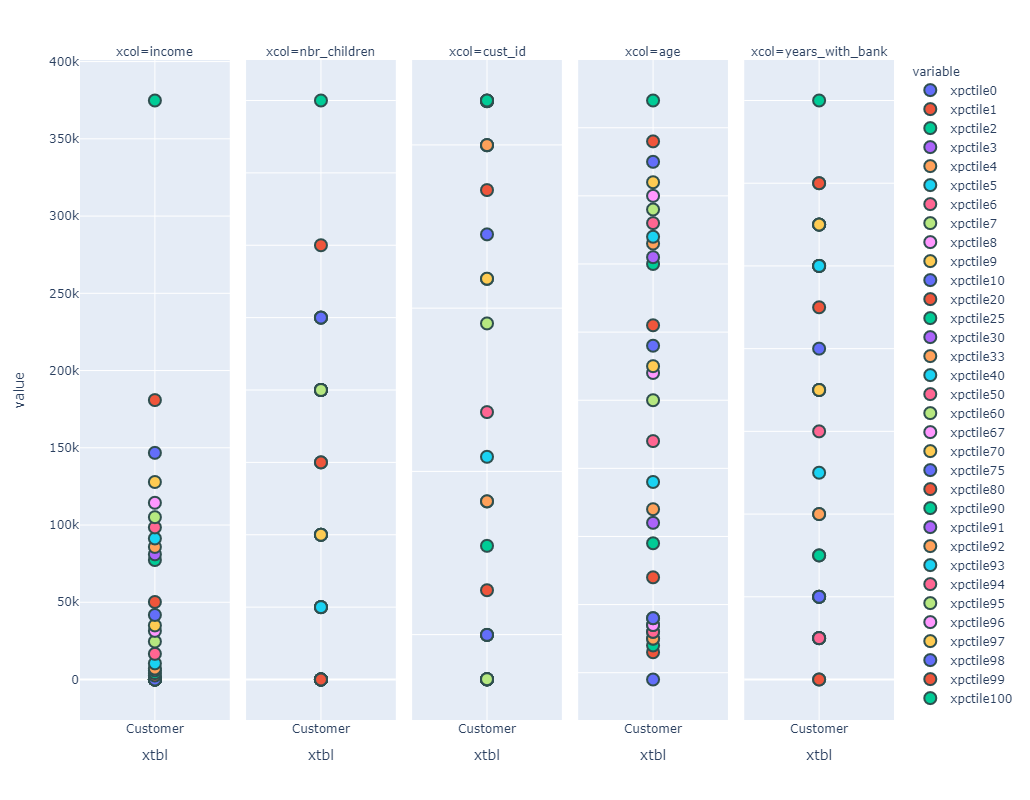

In [18]:
data = tdCustomer_stats2.result.to_pandas().reset_index()
fig = px.scatter(data, facet_col="xcol", x="xtbl",  y= [col for col in data.columns if 'xpctile' in col], height=800)
fig.update_yaxes(matches=None)
fig.update_traces(marker=dict(size=12,line=dict(width=2,color='DarkSlateGrey')),selector=dict(mode='markers'))
fig.show()

In [19]:
# Example 3: Next call the Statistics function on the same variables in the Customer table, generating basic statistics, grouping by gender and filtering anyone with an income of 0.
tdCustomer_stats3 = valib.Statistics(data=tdCustomer, columns="allnumericanddate", group_columns="gender", filter="income > 0")
# Print the results
# Using to_pandas() for a cleaner display format
tdCustomer_stats3.result.to_pandas().head(20)

xcnt        xmin        xmax  \
gender xdb      xtbl     xcol                                              
F      rb255002 Customer income           5054.0       297.4    265943.6   
M      rb255002 Customer cust_id          3976.0  13624800.0  31360339.0   
F      rb255002 Customer nbr_children     5054.0         0.0         8.0   
                         cust_id          5054.0  13624810.0  31360385.0   
                         years_with_bank  5054.0         0.0        14.0   
M      rb255002 Customer age              3976.0        14.0        93.0   
                         years_with_bank  3976.0         0.0        14.0   
                         income           3976.0       197.4    374808.2   
F      rb255002 Customer age              5054.0        14.0        94.0   
M      rb255002 Customer nbr_children     3976.0         0.0         8.0   

                                                 xmean          xstd  
gender xdb      xtbl     xcol                                         
F      rb255002 Customer income           3.038010e+04  3.277318e+04  
M      rb255002 Customer cust_id          2.248957e+07  5.494447e+06  
F      rb255002 Customer nbr_children     1.888603e+00  1.471150e+00  
                         cust_id          2.248928e+07  5.494378e+06  
                         years_with_bank  5.793431e+00  3.023923e+00  
M      rb255002 Customer age              4.890292e+01  1.739675e+01  
                         years_with_bank  5.874748e+00  2.935920e+00  
                         income           4.046579e+04  4.533547e+04  
F      rb255002 Customer age              4.846379e+01  1.683140e+01  
M      rb255002 Customer nbr_children     1.912978e+00  1.526912e+00

### Plots
#### "Box and Whiskers" by Gender Plot

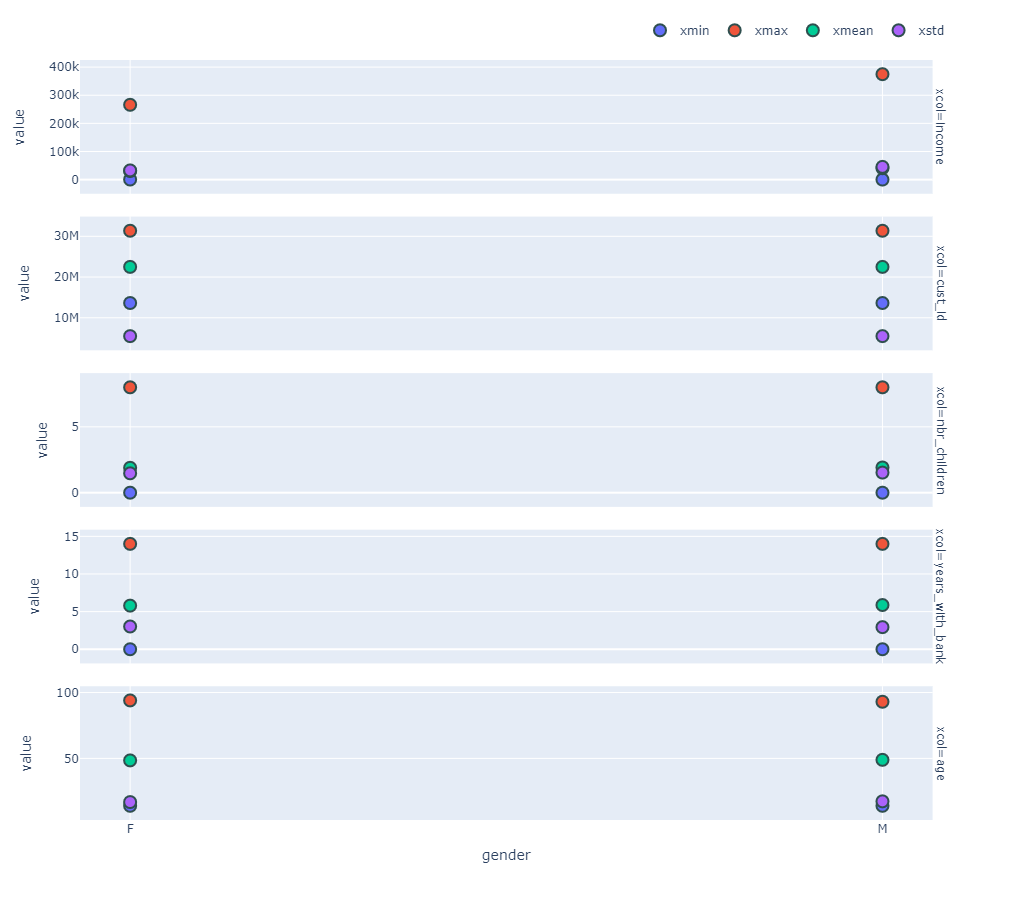

In [20]:
data = tdCustomer_stats3.result.to_pandas().reset_index()
fig = px.scatter(data, facet_row="xcol",  x="gender", y=["xmin","xmax","xmean", "xstd"], height=900)
fig.update_yaxes(matches=None)
fig.update_traces(marker=dict(size=12,line=dict(width=2,color='DarkSlateGrey')),selector=dict(mode='markers'))
fig.update_layout(legend=dict(
    title="",
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

## Frequency Function

### SIGNATURE:
> valib.Frequency(data, columns=None, exclude_columns=None, cumulative_option=False, agg_filter=None, min_percentage=None, pairwise_columns=None, stats_columns=None, style="basic", top_n=None, filter=None)

### DESCRIPTION:
Frequency analysis counts the occurrences of individual data values in columns that contain categorical data. Frequency analysis is useful in understanding the meaning of a particular data element and can point out the need to recode some of the data values found, either permanently or in the course of building an analytic data set. This function is also useful in analyzing combinations of values occurring in two or more columns. 
A Frequency analysis calculates the number of occurrences of each value of the column or columns individually or in combination. Additionally, for each value, the percentage of rows in the selected DataFrame is provided in descending order starting with the most frequently occurring value. 

### PARAMETERS:
data:
Required Argument.
Specifies the input data to perform frequency analysis.
Types: teradataml DataFrame

#### columns:
Required Argument.
Specifies the name(s) of the column(s) to analyze. Occasionally, it can also accept permitted strings to specify all columns, or all numeric columns, or all character columns.
Permitted Values: 
- Name(s) of the column(s) in "data".
- Pre-defined strings: 
    - 'all' – all columns
    - 'allnumeric' – all numeric columns
    - 'allcharacter' - all numeric and date columns

Types: str OR list of Strings (str)

#### exclude_columns:
Optional Argument.
Specifies the name(s) of the column(s) to exclude from the analysis, if a column specifier such as 'all', 'allnumeric', 'allcharacter' is used in the "columns" argument.

Types: str OR list of Strings (str)

#### cumulative_option:
Optional Argument.
Specifies whether to include rank, cumulative count, and cumulative percent information for each frequency value. When set to 'True', this information is included otherwise not.
Note:
    This argument should not be set to 'True' when style is 'pairwise'.
Default Value: False

Types: bool

#### agg_filter:
Optional Argument.
Specifies the clause to restrict returned aggregations.
For example,
    agg_filter="xpct > 1"
Note:
    This argument should not be used when "min_percentage" argument is used.

Types: str

#### min_percentage:
Optional Argument.
Specifies a value to determine whether to include only frequency values that occur a minimum percentage of the time. Setting this to 0 or 0.0 is equivalent to not including the argument at all. 

Types: float, int

#### pairwise_columns:
Optional Argument.
Specified the columns to be paired up with the frequency columns.
Note:
    Use only when "style" is set to 'pariwise'.

Types: str OR list of Strings (str)

#### stats_columns:
Optional Argument.
Specifies the name(s) of column(s) for which the minimum, maximum, mean value, and standard deviation are included in the result with the values computed over the rows corresponding to the individual values of the frequency columns.
Note:
    This argument can be used only when "style" is 'basic'.

Types: str OR list of Strings (str)

#### style:
Optional Argument.
Specifies the frequency style for the analysis.
Permitted Values:
- 'basic' - Counts frequencies of individual column values.
- 'pairwise' - Counts frequencies of pair-wise combinations of values of selected columns rather than individually. This should not be used when "cumulative_option" is set to 'True'.
- 'crosstab' - Counts frequencies of combinations of values of selected columns rather than individually.

Default Value: 'basic'

Types: str

#### top_n:
Optional Argument.
Specifies the number of frequency values to include. Using this argument shows frequency only for the number of top occurring values entered. 
Note:
    This argument is enabled only if "cumulative_option" is set to 'True'.

Types: int

#### filter:
Optional Argument.
Specifies the clause to filter rows selected for analysis within Frequency.
For example,
    filter = "cust_id > 0"

Types: str

### RETURNS:
An instance of Frequency.
Output teradataml DataFrames can be accessed using attribute references, such as FrequencyObj.<attribute_name>.
Output teradataml DataFrame attribute name is: result.

### RAISES:
TeradataMlException, TypeError, ValueError

In [21]:
# Example 1: First call the Frequency function on the years_with_bank column in the Customer table.
tdCustomer_freq1 = valib.Frequency(data=tdCustomer, columns="years_with_bank")
# Print the results
# Using to_pandas() for a cleaner display format
tdCustomer_freq1.result.to_pandas().head(20)

xcnt       xpct
xtbl     xcol            xval                   
Customer years_with_bank 10     613.0   5.861541
                         7     1118.0  10.690381
                         9      845.0   8.079939
                         13      45.0   0.430293
                         12     182.0   1.740295
                         8     1014.0   9.695927
                         4     1137.0  10.872060
                         5     1190.0  11.378849
                         1      526.0   5.029642
                         11     374.0   3.576210
                         2      888.0   8.491107
                         0      176.0   1.682922
                         6     1151.0  11.005928
                         3     1160.0  11.091987
                         14      39.0   0.372920

### Box Plot - Number of years with the financial institution

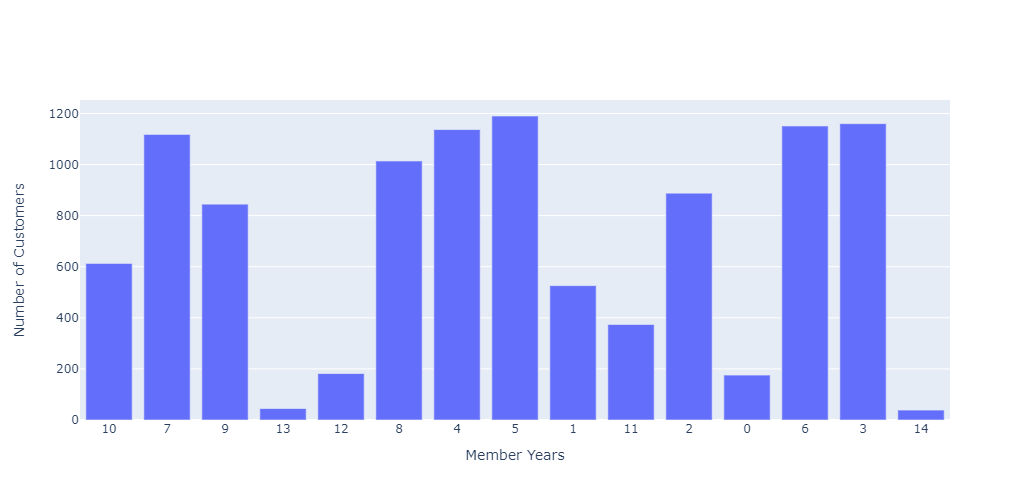

In [23]:
import plotly.graph_objs as go

data = tdCustomer_freq1.result.to_pandas().reset_index()

fig = go.Figure(data=[go.Bar(x=data.xval, y=data.xcnt)])
fig.update_layout(height=500)
fig.update_yaxes(title="Number of Customers")
fig.update_xaxes(title="Member Years", dtick=1)
fig.update_layout(showlegend=False)
fig.show() 

In [24]:
# Example 2: Next call the Frequency function on the gender and marital_status columns in the Customer table, generating a cross-tabulation.
tdCustomer_freq2 = valib.Frequency(data=tdCustomer, columns=["gender", "marital_status"], style="crosstab")
# Print the results
# Using to_pandas() for a cleaner display format
tdCustomer_freq2.result.to_pandas().head(20)

xcnt       xpct
gender marital_status                   
F      4                560.0   5.354752
       1               2226.0  21.285141
M      4                420.0   4.016064
       1               1638.0  15.662651
F      2               2646.0  25.301205
M      3                252.0   2.409639
       2               2296.0  21.954485
F      3                420.0   4.016064

### Box Plot - Gender by Marital Status

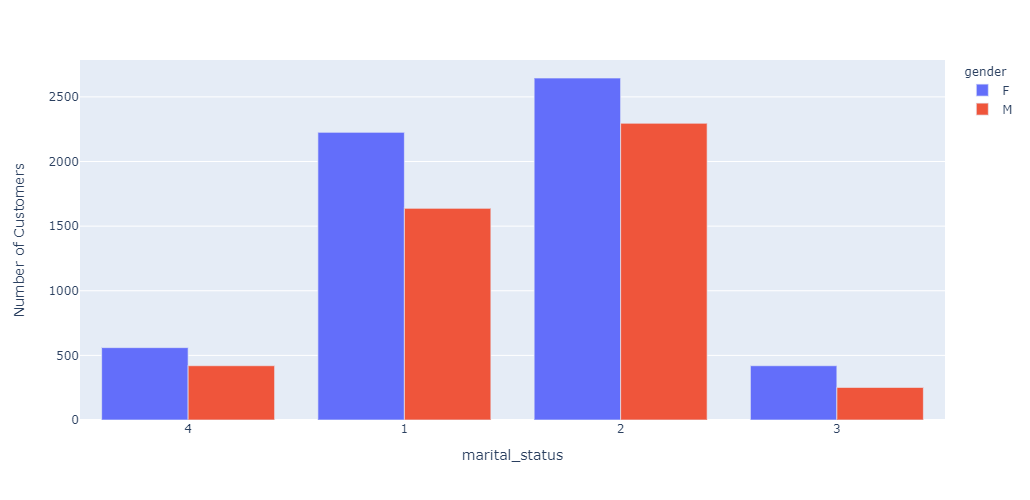

In [25]:
data = tdCustomer_freq2.result.to_pandas().reset_index()
# get center and width
fig = px.bar(data, x="marital_status", y="xcnt",
             color='gender', barmode='group',
             height=500)

fig.update_yaxes(title="Number of Customers")

fig.show()

### Box Plot - Marital Status by Gender

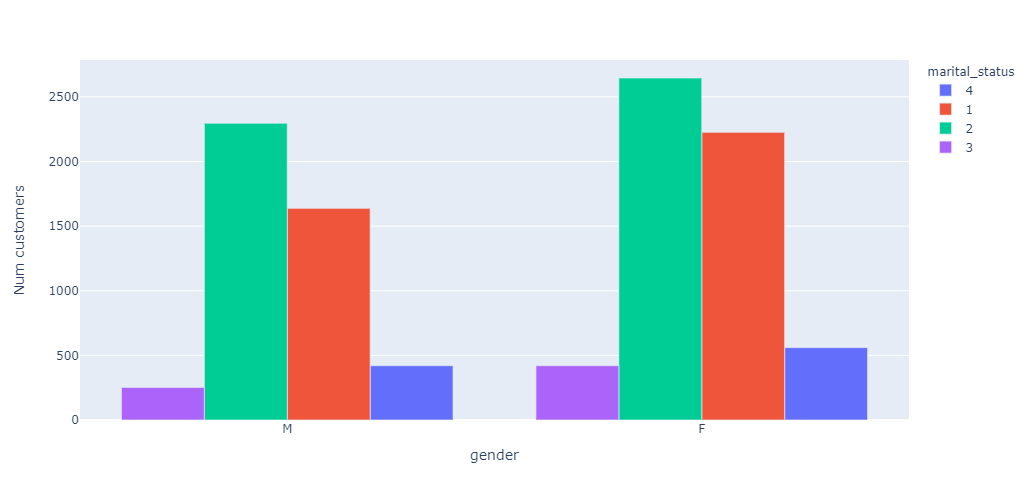

In [26]:
data = tdCustomer_freq2.result.to_pandas().reset_index()
# get center and widht
fig = px.bar(data, x="gender", y="xcnt",
             color='marital_status', barmode='group',
             height=500)

fig.update_yaxes(title="Num customers")

fig['layout']['xaxis']['autorange'] = "reversed"
fig.show()

In [27]:
# Example 3: Next call the Frequency function on the state_code column in the Customer table, taking statistics on income.
tdCustomer_freq3 = valib.Frequency(data=tdCustomer, columns="state_code", stats_columns="income")
# Print the results
# Using to_pandas() for a cleaner display format
tdCustomer_freq3.result.to_pandas().head(50)

xcnt       xpct  xmin_income  xmax_income  \
xtbl     xcol       xval                                                
Customer state_code DC      84.0   0.803213       1761.5      67155.4   
                    TN     252.0   2.409639       1124.8     205548.2   
                    NB      42.0   0.401606       2624.1      94458.0   
                    NY    1498.0  14.323963          0.0     234644.8   
                    NJ     168.0   1.606426          0.0     129040.6   
                    KS      42.0   0.401606          0.0      51966.2   
                    WI     210.0   2.008032        464.0     241956.0   
                    CA    2478.0  23.694779          0.0     332404.8   
                    AL      56.0   0.535475       1649.4      39361.4   
                    IN     224.0   2.141901          0.0     174018.0   
                    MO     238.0   2.275770          0.0     179225.8   
                    WA     126.0   1.204819       1207.3      80704.0   
                    MD     112.0   1.070950          0.0     143158.6   
                    FL     224.0   2.141901          0.0     288610.4   
                    MN     182.0   1.740295          0.0     151364.2   
                    AZ     336.0   3.212851          0.0     218712.0   
                    TX    1162.0  11.111111          0.0     374808.2   
                    VA      70.0   0.669344          0.0     225534.4   
                    NC     126.0   1.204819        856.5     202090.2   
                    CO     154.0   1.472557        840.6     248521.0   
                    IL     784.0   7.496653          0.0     335909.6   
                    HI     182.0   1.740295          0.0     103849.2   
                    OR     224.0   2.141901          0.0     146291.6   
                    OK     224.0   2.141901          0.0     112860.8   
                    OH     322.0   3.078983          0.0     169062.4   
                    MI     126.0   1.204819          0.0     198577.6   
                    PA     294.0   2.811245          0.0     223743.0   
                    NM      98.0   0.937082          0.0     159380.0   
                    GA      28.0   0.267738       2372.2      77578.8   
                    LA      42.0   0.401606       1673.9      59235.8   
                    NV      56.0   0.535475          0.0      67990.0   
                    MA     112.0   1.070950          0.0     108290.0   
                    KY     182.0   1.740295          0.0     113955.4   

                          xmean_income   xstd_income  
xtbl     xcol       xval                              
Customer state_code DC    22586.242857  16019.276711  
                    TN    28472.663492  32040.450997  
                    NB    31007.771429  23224.028780  
                    NY    31286.770628  36219.221794  
                    NJ    24440.998810  27981.736222  
                    KS    12033.150000  14476.031429  
                    WI    27768.799048  37459.286544  
                    CA    30083.408232  37805.364991  
                    AL    15880.569643  10439.297059  
                    IN    27219.521429  31555.337281  
                    MO    29935.244958  33307.699932  
                    WA    24925.124603  19459.314381  
                    MD    28649.943750  33918.205582  
                    FL    38774.348214  47838.489609  
                    MN    22906.390659  27455.956889  
                    AZ    30712.773810  34379.197988  
                    TX    34697.395267  46655.502401  
                    VA    46076.702857  57621.290044  
                    NC    49419.738889  45999.611855  
                    CO    31333.554545  43146.241835  
                    IL    36907.453954  50081.273551  
                    HI    15677.484615  21641.469467  
                    OR    16353.408036  24154.386166  
                    OK    21036.735268  24375.662008  
                    OH    21638.146584  26

### Box Plot - Membership by State

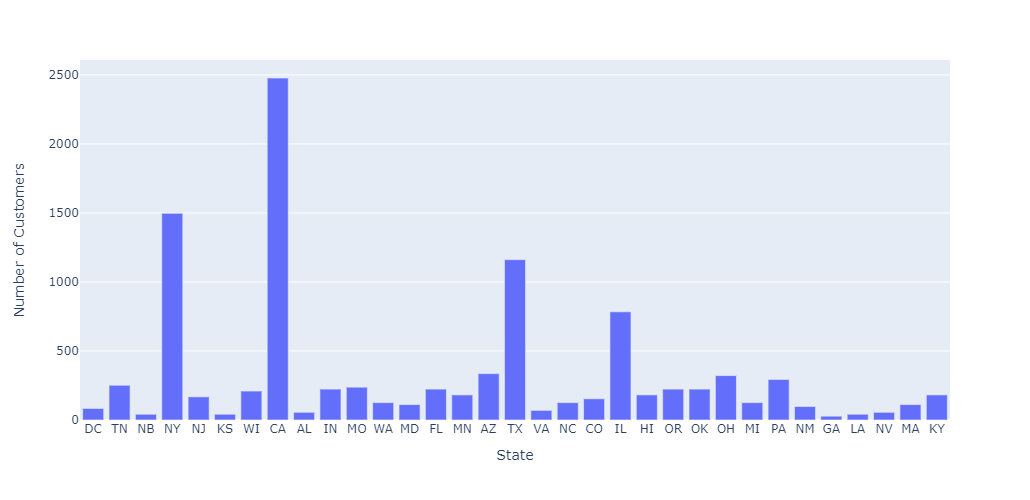

In [29]:
data = tdCustomer_freq3.result.to_pandas().reset_index()
# get center and widht
fig = px.bar(data, x="xval", y="xcnt",height=500)
fig.update_xaxes(title="State")
fig.update_yaxes(title="Number of Customers")
fig.show()

### Box Plot - "Box and Whiskers" Income Levels by State

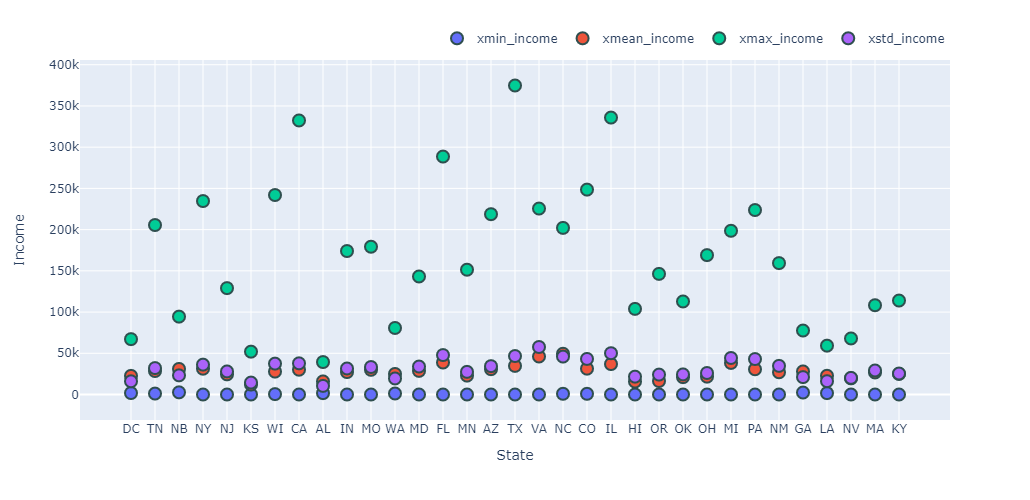

In [30]:
data = tdCustomer_freq3.result.to_pandas().reset_index()
fig = px.scatter(data, x="xval", y=["xmin_income","xmean_income","xmax_income","xstd_income"],height=500,width=1000)
fig.update_traces(marker=dict(size=12,line=dict(width=2,color='DarkSlateGrey')),selector=dict(mode='markers'))
fig.update_layout(legend=dict(
    title="",
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig.update_yaxes(title="Income")
fig.update_xaxes(title="State")

fig.show()

## Histogram Function

### SIGNATURE:
> valib.Histogram(data, columns=None, bins=10, bins_with_boundaries=None, boundaries=None, quantiles=10, widths=None, exclude_columns=None, overlay_columns=None, stats_columns=None, hist_style="basic", filter=None)

### DESCRIPTION:
Histogram analysis reveals the distribution of continuous numeric or date values in a column. Histogram analysis is also referred to as binning because it counts the occurrence of values in a series of numeric ranges called bins. The histogram analysis provides a number of ways to define bins, allowing multidimensional binning, overlaying of categorical data, and the calculation of numeric statistics within bins. If you set the desired number of equal sized data bins, the desired number of bins with a nearly equal number of values, a desired width, or the specific boundaries, the Histogram analysis separates the data to show its distributional properties. It does this by separating the data by bin number and gives counts and percentages over the requested rows. Percentages always sum to 100%. Separate options are available to specify a number of equal sized data bins in which the analysis determines the minimum and maximum value, as well as a user-specified minimum and maximum value. If the minimum and maximum are specified, all values less than the minimum are put in bin 0, while all values greater than the maximum are put in bin N+1. The same is true when the boundary option is specified. 
The Histogram analysis optionally provides subtotals within each bin of the count, percentage within the bin and percentage overall for each value or combination of values of one or more overlaid columns. Another option is provided to collect simple statistics for a binned column or another column of numeric or date type within the table, providing the minimum, maximum, mean, and standard deviation. When statistics are collected for a date type column, the standard deviation is given in units of days.Histogram analysis can be performed on columns of numeric or date data type.

### PARAMETERS:

#### data:
Required Argument.
Specifies the input data to perform Histogram analysis.
Types: teradataml DataFrame

#### columns:
Required Argument.
Specifies the name(s) of the column(s) to analyze. Occasionally, it can also accept permitted strings to specify all columns, or all numeric columns, or all numeric and date columns.
Permitted Values: 
- Name(s) of the column(s) in "data".
- Pre-defined strings: 
    - 'all' – all columns
    - 'allnumeric' – all numeric columns
    - 'allnumericanddate' - all numeric and date columns

Types: str OR list of Strings (str)

#### bins:
Optional Argument.
Specifies the number of equal width bins to create.
If multiple columns are requested, multiple bin sizes may be specified, such as bins = [5, 10]. If fewer sizes are specified than columns, left-over columns are associated with the default size of 10 bins.
Default Value: 10

Types: int OR list of Integers (int)

#### bins_with_boundaries:
Optional Argument.
Specifies the number of bins spanning a range specified by the minimum and maximum values.
For example, 
    bins_with_boundaries = [5,0,200] 
    creates 5 bins ranging from 0 to 200. 
If multiple columns are requested, multiple sets of parameters must be specified, such as bins_with_boundaries = ["{10, 0, 200000}", "{5, 0, 100}"]. Note that multiple values are provided as string with numbers enclosed in curly braces '{}'. Each such value corresponds to the value in "columns" argument.

Types: int, str OR list of Integers (int) or Strings (str)

#### boundaries:
Optional Argument.
Specifies the boundaries that define the bins.
For example, 
    boundaries = [0,50,100,150]
    provides 3 bins between 0 and 150 (0 to 50, 50 to 100, and 100 to 150). 
If multiple columns are requested, multiple sets of parameters must be specified, such as boundaries = ["{0, 50000, 100000, 150000}", "{0, 50, 100}"]. Note that multiple values are provided as string with numbers enclosed in curly braces '{}'. Each such value corresponds to the value in "columns" argument.

Types: int, str OR list of Integers (int) or Strings (str)

#### quantiles:
Optional Argument.
Specifies the number of approximately equally populated bins to create.
If multiple columns are requested, multiple quantile sizes may be specified, such as quantiles=5, 10. If fewer sizes are specified than columns, left-over columns are associated with the default size of 10 quantiles.
Default Value: 10

Types: int OR list of Integers (int)

#### widths: 
Optional Argument.
Specifies the width of the bins to create.
If multiple columns are requested, multiple widths must be specified, such as widths = [5, 10]. If fewer sizes are specified than columns, an error message displays.

Types: int OR list of Integers (int)

#### exclude_columns:
Optional Argument.
Specifies the name(s) of the column(s) to exclude from the analysis, if a column specifier such as 'all', 'allnumeric', 'allnumericanddate' is used in the "columns" argument.

Types: str OR list of Strings (str)

#### overlay_columns:
Optional Argument.
Specifies a categorical variable with only a few values. If an overlay column is specified, frequencies within each bin are calculated for each value of that overlay column (frequencies for crosstabs of values are given if more than one overlay column is requested). 
Note:
    Use a specific column in either "overlay_columns" or "stats_columns", but not both.

Types: str OR list of Strings (str)

#### stats_columns:
Optional Argument.
Specifies a list of numeric columns/aliases for which simple statistics are calculated (minimum, maximum, mean and standard deviation) in each bin. This argument is not available for DATE columns.
Note:
    Use a specific column in either "overlay_columns" or "stats_columns", but not both.

Types: str OR list of Strings (str)

#### hist_style:
Optional Argument.
Specifies the histogram style to use for analysis.
Permitted Values:
- 'basic' - Creates a histogram for individual columns.
- 'crosstab' - Creates a multidimensional histogram by combining columns.
Default Value: 'basic'

Types: str

#### filter:
Optional Argument.
Specifies the clause to filter rows selected for analysis within Histogram.
For example,
    filter = "cust_id > 0"

Types: str

### RETURNS:
An instance of Histogram.
Output teradataml DataFrames can be accessed using attribute references, such as HistogramObj.<attribute_name>.
Output teradataml DataFrame attribute name is: result.

### RAISES:
TeradataMlException, TypeError, ValueError

In [31]:
# Example 1: Perform Histogram analysis on income by specifying number of "bins" to show skewed distribution
tdCustomer_hist1 = valib.Histogram(data=tdCustomer, columns="income", bins=25)
# Print the results
# Using to_pandas() for a cleaner display format
tdCustomer_hist1.result.to_pandas().head(25)

Empty DataFrame
Columns: []
Index: [(rb255002, Customer, income, 6, 74961.64, 89953.968, 344.0, 3.2893478676611205), (rb255002, Customer, income, 7, 89953.968, 104946.296, 232.0, 2.2183973991202905), (rb255002, Customer, income, 9, 119938.624, 134930.952, 109.0, 1.0422642952763435), (rb255002, Customer, income, 20, 284854.232, 299846.56, 4.0, 0.038248231019315355), (rb255002, Customer, income, 12, 164915.608, 179907.936, 42.0, 0.40160642570281124), (rb255002, Customer, income, 1, 0.0, 14992.328, 4974.0, 47.56167527251865), (rb255002, Customer, income, 4, 44976.984, 59969.312, 773.0, 7.391470644482693), (rb255002, Customer, income, 22, 314838.888, 329831.216, 2.0, 0.019124115509657678), (rb255002, Customer, income, 11, 149923.28, 164915.608, 47.0, 0.4494167144769554), (rb255002, Customer, income, 5, 59969.312, 74961.64, 522.0, 4.991394148020654), (rb255002, Customer, income, 3, 29984.656, 44976.984, 1206.0, 11.53184165232358), (rb255002, Customer, income, 2, 14992.328, 29984.656, 1882.0, 17.995792694587877), (rb255002, Customer, income, 23, 329831.216, 344823.544, 3.0, 0.02868617326448652), (rb255002, Customer, income, 19, 269861.904, 284854.232, 3.0, 0.02868617326448652), (rb255002, Customer, income, 14, 194900.264, 209892.592, 23.0, 0.2199273283610633), (rb255002, Customer, income, 10, 134930.952, 149923.28, 66.0, 0.6310958118187033), (rb255002, Customer, income, 15, 209892.592, 224884.92, 17.0, 0.16255498183209027), (rb255002, Customer, income, 21, 299846.56, 314838.888, 1.0, 0.009562057754828839), (rb255002, Customer, income, 25, 359815.872, 374808.2, 2.0, 0.019124115509657678), (rb255002, Customer, income, 13, 179907.936, 194900.264, 32.0, 0.30598584815452284), (rb255002, Customer, income, 16, 224884.92, 239877.248, 9.0, 0.08605851979345955), (rb255002, Customer, income, 8, 104946.296, 119938.624, 153.0, 1.4629948364888123), (rb255002, Customer, income, 17, 239877.248, 254869.576, 4.0, 0.038248231019315355), (rb255002, Customer, income, 18, 254869.576, 269861.904, 8.0, 0.07649646203863071)]

### Histogram of Income - 25 even width bins

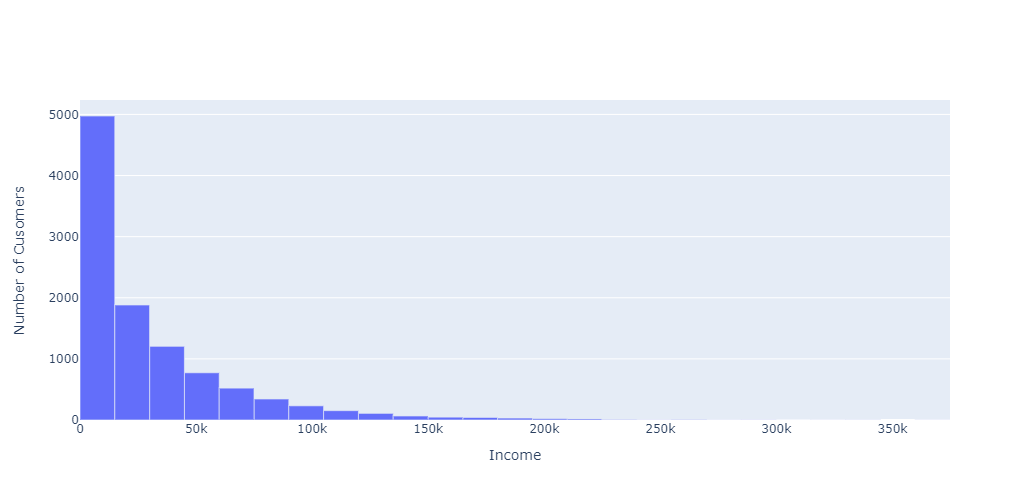

In [32]:
data = tdCustomer_hist1.result.to_pandas().reset_index()
data["xcenter"] =  (data.xend + data.xbeg) / 2
data["xwidth"] =  data.xend - data.xbeg
fig = go.Figure(data=[go.Bar(x=data.xcenter, y=data.xcnt, width=data.xwidth)])

fig.update_layout(height=500)
fig.update_yaxes(title="Number of Cusomers")
fig.update_xaxes(title="Income")
fig.update_layout(showlegend=False)
fig.show() 

In [33]:
# Example 2: Perform Histogram analysis on income using "quantiles" to show skewed distribution
tdCustomer_hist2 = valib.Histogram(data=tdCustomer, columns="income", quantiles=25)
# Print the results.
# Using to_pandas() for a cleaner display format
tdCustomer_hist2.result.to_pandas().head(25)

Empty DataFrame
Columns: []
Index: [(rb255002, Customer, income, 5, 1369.6, 2564.4, 418.0, 3.9969401415184547), (rb255002, Customer, income, 17, 28409.7, 32552.0, 418.0, 3.9969401415184547), (rb255002, Customer, income, 24, 85826.0, 114388.0, 418.0, 3.9969401415184547), (rb255002, Customer, income, 11, 10444.5, 12710.0, 417.0, 3.987378083763626), (rb255002, Customer, income, 14, 17954.3, 20996.7, 418.0, 3.9969401415184547), (rb255002, Customer, income, 18, 32581.0, 37763.0, 418.0, 3.9969401415184547), (rb255002, Customer, income, 9, 6605.0, 8423.0, 418.0, 3.9969401415184547), (rb255002, Customer, income, 16, 24596.0, 28402.0, 419.0, 4.006502199273283), (rb255002, Customer, income, 15, 20996.8, 24582.6, 418.0, 3.9969401415184547), (rb255002, Customer, income, 21, 50191.9, 58806.0, 418.0, 3.9969401415184547), (rb255002, Customer, income, 1, 0.0, 0.0, 1428.0, 13.654618473895582), (rb255002, Customer, income, 23, 69582.0, 85820.0, 418.0, 3.9969401415184547), (rb255002, Customer, income, 25, 114448.0, 374808.2, 418.0, 3.9969401415184547), (rb255002, Customer, income, 20, 43456.0, 50180.0, 418.0, 3.9969401415184547), (rb255002, Customer, income, 6, 2567.8, 3859.2, 418.0, 3.9969401415184547), (rb255002, Customer, income, 12, 12712.0, 15351.0, 418.0, 3.9969401415184547), (rb255002, Customer, income, 19, 37770.0, 43449.3, 419.0, 4.006502199273283), (rb255002, Customer, income, 13, 15355.6, 17952.2, 419.0, 4.006502199273283), (rb255002, Customer, income, 8, 5187.6, 6591.3, 418.0, 3.9969401415184547), (rb255002, Customer, income, 7, 3861.3, 5184.4, 419.0, 4.006502199273283), (rb255002, Customer, income, 4, 197.4, 1363.5, 246.0, 2.3522662076878946), (rb255002, Customer, income, 22, 58834.0, 69515.2, 419.0, 4.006502199273283), (rb255002, Customer, income, 10, 8424.0, 10443.5, 420.0, 4.016064257028113)]

### Histogram of Income - 25 Quantile bins

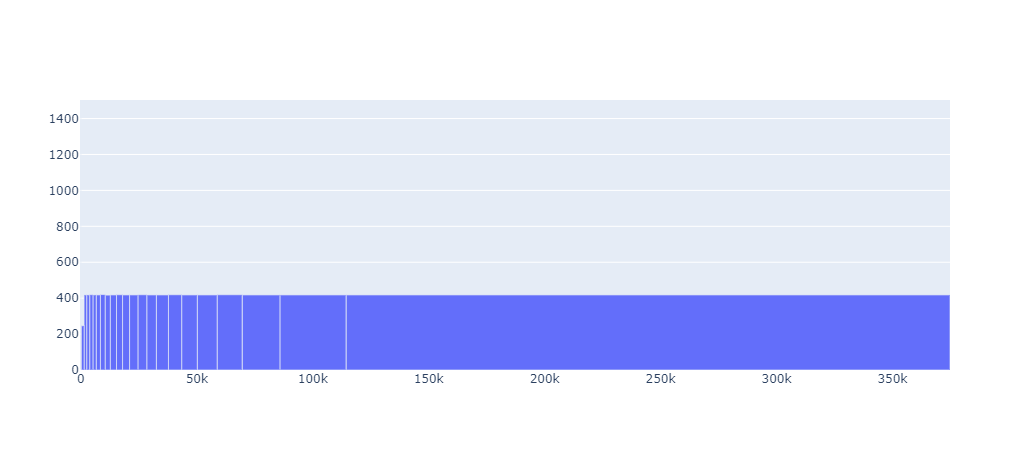

In [36]:
data = tdCustomer_hist2.result.to_pandas().reset_index()
# get center and widht
income_center = (data.xend + data.xbeg) / 2
income_width = data.xend - data.xbeg
count = data.xcnt
fig = go.Figure(data=[go.Bar(x=income_center, y=count, width=income_width)])
fig.show()

In [37]:
# Example 3: Perform Histogram analysis on age, overlayed by state_code
tdCustomer_hist3 = valib.Histogram(data=tdCustomer, columns="income", bins=25, overlay_columns="state_code")
# Print the results
# Using to_pandas() for a cleaner display format
tdCustomer_hist3.result.to_pandas().head(25)

xocnt  \
xdb      xtbl     xcol   xbin xbeg       xend       xcnt   xpct      ovly_state_code          
rb255002 Customer income 5    59969.312  74961.640  522.0  4.991394  IL                31.0   
                         1    0.000      14992.328  4974.0 47.561675 NC                47.0   
                                                                     CO                72.0   
                         6    74961.640  89953.968  344.0  3.289348  NY                58.0   
                         4    44976.984  59969.312  773.0  7.391471  NM                 6.0   
                         2    14992.328  29984.656  1882.0 17.995793 WI                47.0   
                         4    44976.984  59969.312  773.0  7.391471  GA                 2.0   
                         2    14992.328  29984.656  1882.0 17.995793 NJ                25.0   
                         1    0.000      14992.328  4974.0 47.561675 PA               162.0   
                         6    74961.640  89953.968  344.0  3.289348  MA                 6.0   
                         5    59969.312  74961.640  522.0  4.991394  WA                 7.0   
                         6    74961.640  89953.968  344.0  3.289348  KY                 6.0   
                         11   149923.280 164915.608 47.0   0.449417  MN                 1.0   
                         4    44976.984  59969.312  773.0  7.391471  MA                11.0   
                         2    14992.328  29984.656  1882.0 17.995793 NM                15.0   
                                                                     AL                22.0   
                         10   134930.952 149923.280 66.0   0.631096  AZ                 1.0   
                         1    0.000      14992.328  4974.0 47.561675 NB                12.0   
                         4    44976.984  59969.312  773.0  7.391471  MO                17.0   
                         3    29984.656  44976.984  1206.0 11.531842 TN                37.0   
                                                                     NM                 6.0   
                         6    74961.640  89953.968  344.0  3.289348  CA                81.0   
                         3    29984.656  44976.984  1206.0 11.531842 IL                80.0   
                         5    59969.312  74961.640  522.0  4.991394  OH                 9.0   
                         3    29984.656  44976.984  1206.0 11.531842 DC                14.0   

                                                                                         xobpct  \
xdb      xtbl     xcol   xbin xbeg       xend       xcnt   xpct      ovly_state_code              
rb255002 Customer income 5    59969.312  74961.640  522.0  4.991394  IL                5.938697   
                         1    0.000      14992.328  4974.0 47.561675 NC                0.944914   
                                                                     CO                1.447527   
                         6    74961.640  89953.968  344.0  3.289348  NY               16.860465   
                         4    44976.984  59969.312  773.0  7.391471  NM                0.776197   
                         2    14992.328  29984.656  1882.0 17.995793 WI                2.497343   
                         4    44976.984  59969.312  773.0  7.391471  GA                0.258732   
                         2    14992.328  29984.656  1882.0 17.995793 NJ                1.328374   
                         1    0.000      14992.328  4974.0 47.561675 PA                3.256936   
                         6    74961.640  89953.968  344.0  3.289348  MA                1.744186   
                         5    59969.312  74961.640  522.0  4.991394  WA                1.340996   
                         6    74961.640  89953.968  344.0  3.289348  KY                1.744186   
                         11   149923.280 164915.608 47.0   0.449417  MN                2.127660   
                         4    44976

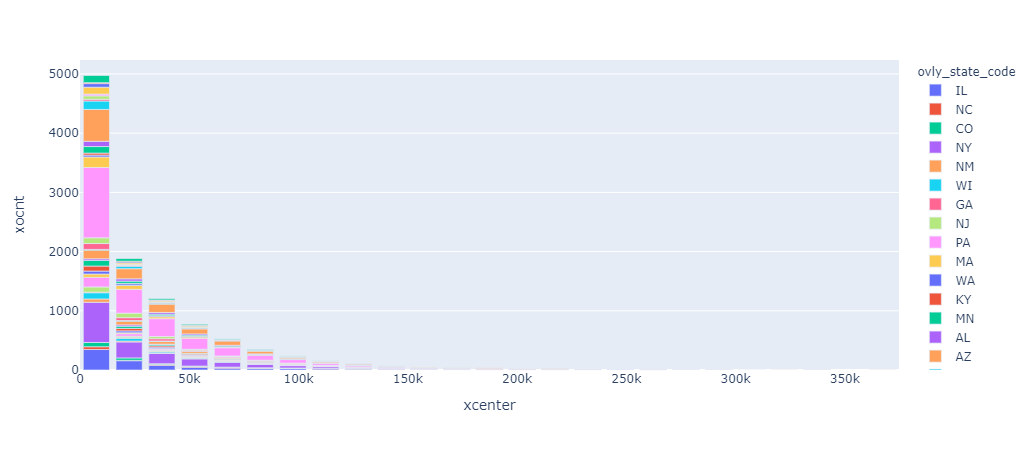

In [38]:
data = tdCustomer_hist3.result.to_pandas().reset_index()
# get center and widht
data["xcenter"] =  (data.xend + data.xbeg) / 2
data["xwidth"] =  data.xend - data.xbeg
fig = px.bar(data, x="xcenter", y="xocnt", color="ovly_state_code")
fig.show()


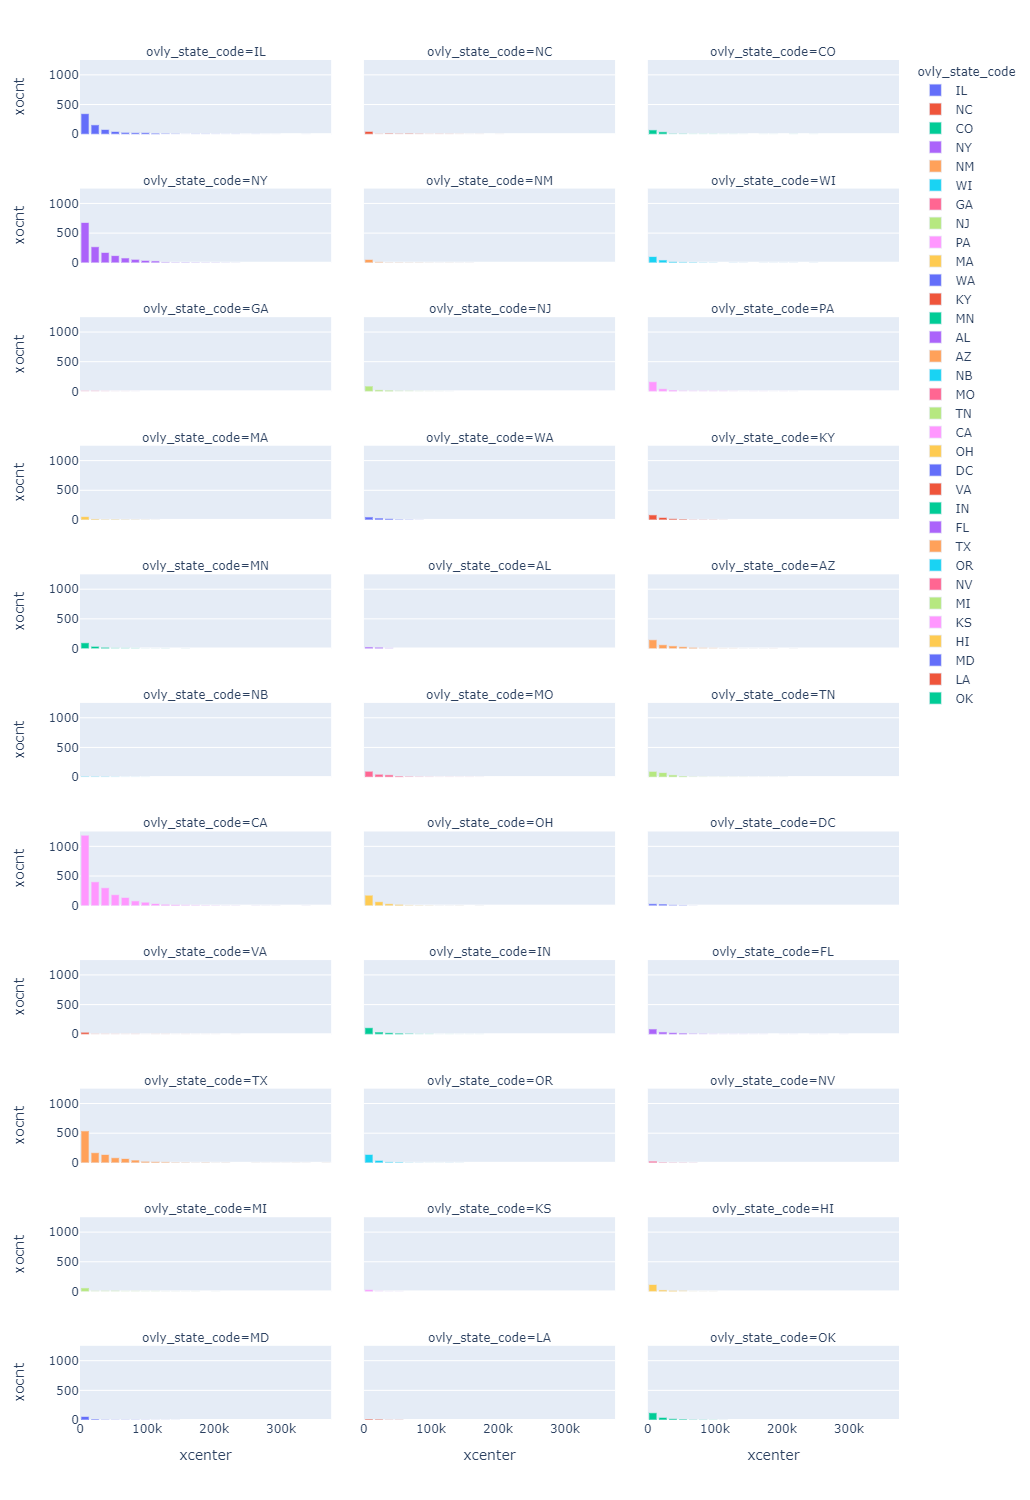

In [39]:
data = tdCustomer_hist3.result.to_pandas().reset_index()
# get center and widht
data["xcenter"] =  (data.xend + data.xbeg) / 2
data["xwidth"] =  data.xend - data.xbeg
fig = px.bar(data, x="xcenter", y="xocnt", facet_col="ovly_state_code", color="ovly_state_code", facet_col_wrap=3,
              facet_row_spacing=0.04, # default is 0.07 when facet_col_wrap is used
              facet_col_spacing=0.04, # default is 0.03
              height=1500, width=1200,)
fig.show()

# Data Preparation

## Transform Function

### SIGNATURE:
>valib.Transform(data, bins=None, derive=None, one_hot_encode=None, fillna=None, label_encode=None, rescale=None, retain=None, sigmoid=None, zscore=None, fallback=False, index_columns=None, unique_index=False, key_columns=None, allow_duplicates=None, nopi=None, filter=None)

### DESCRIPTION:

The Variable Transformation analysis reads a teradataml DataFrame and produces an output containing transformed columns. This is useful when preparing data for input to an analytic algorithm. For example, a K-Means Clustering algorithm typically produces better results when the input columns are first converted to their Z-Score values to put all input variables on an equal footing, regardless of their magnitude. 
Function supports following transformations:

- Binning – Binning replaces a continuous numeric column with a categorical one to produce ordinal values (for example, numeric categorical values where order is meaningful).
- Derive – The Derive transformation requires the free-form transformation be specified as a formula.
- One Hot Encoding – One Hot Encoding is useful when a categorical data element must be re-expressed as one or more numeric data elements, creating a binary numeric field for each categorical data value.
- Missing Value Treatment or Null Replacement.
- Label Encoding – Allows to re-express existing values of a categorical data column (variable) into a new coding scheme or to correct data quality problems and focus an analysis on a value.
- Min-Max Scaling – Limits the upper and lower boundaries of the data in a continuous numeric column using a linear rescaling function based on maximum and minimum data values.
- Retain - Allows copying of one or more columns into the final analytic data set.
- Sigmoid – Provides rescaling of continuous numeric data using a type of sigmoid or s-shaped function.
- ZScore – Provides rescaling of continuous numeric data using Z-Scores.

### PARAMETERS:

#### data:
Required Argument.
Specifies the input data to perform variable transformations.

Types: teradataml DataFrame

#### bins:
Optional Argument.
Specifies one or more instances of Binning Transformation. Binning replaces a continuous numeric column with a categorical one to produce ordinal values (for example, numeric categorical values where order is meaningful). Check the documentation of 'teradataml.analytics.Transformation.Binning' to know more about Binning.

Types: Binning OR List of Binning

#### derive:
Optional Argument.
Specifies one or more instances of Derive Transformation. This argument allows user to perform a free form transformation using arithmetic formula. Check the documentation of 'teradataml.analytics.Transformation.Derive' to know more about Derive.

Types: Derive OR List of Derive

#### one_hot_encode:
Optional Argument.
Specifies one or more instances of OneHotEncoder Transformation. One hot encoding allows user to re-express categorical data as one or more numeric data elements, creating a binary numeric field for each categorical data value. Check the documentation of 'teradataml.analytics.Transformation.OneHotEncoder' to know more about OneHotEncoder.

Types: OneHotEncoder OR List of OneHotEncoder

#### fillna:
Optional Argument.
Specifies one or more instances of FillNa Transformation. This argument allows user to perform a missing value/null replacement transformation. Check the documentation of 'teradataml.analytics.Transformation.FillNa' to know more about FillNa.

Types: FillNa OR List of FillNa

#### label_encode:
Optional Argument.
Specifies one or more instances of LabelEncoder Transformation. This allows to re-express existing values of a categorical data column (variable) into a new coding scheme. Check the documentation of 'teradataml.analytics.Transformation.LabelEncoder' to know more about LabelEncoder.

Types: LabelEncoder OR List of LabelEncoder

#### rescale:
Optional Argument.
Specifies one or more instances of MinMaxScalar Transformation. This limits the upper and lower boundaries of the data in a continuous numeric column using a linear rescaling function based on maximum and minimum data values. Check the documentation of 'teradataml.analytics.Transformation.MinMaxScalar' to know more about MinMaxScalar.

Types: MinMaxScalar OR List of MinMaxScalar

#### retain:
Optional Argument.
Specifies one or more instances of Retain Transformation. This argument allows user to retain columns from input to output. Check the documentation of 'teradataml.analytics.Transformation.Retain' to know more about Retain.

Types: Retain OR List of Retain

#### sigmoid:
Optional Argument.
Specifies one or more instances of Sigmoid Transformation. This argument allows user to perform a rescaling using sigmoid transformation. Check the documentation of 'teradataml.analytics.Transformation.Sigmoid' to know more about Sigmoid.

Types: Sigmoid OR List of Sigmoid

#### zscore:
Optional Argument.
Specifies one or more instances of ZScore Transformation. This argument allows user to perform a rescaling using Z-Score transformation. Check the documentation of 'teradataml.analytics.Transformation.ZScore' to know more about ZScore.

Types: ZScore OR List of ZScore

#### fallback:
Optional Argument.
Specifies whether a mirrored copy of underlying table of output DataFrame is required or not.
Default Value: False

Types: bool

#### index_columns:
Optional Argument.
Specifies the name(s) of the output column(s) to be used as index in output DataFrame.

Types: str OR List of Strings (str)

#### unique_index:
Optional Argument.
Specifies whether the underlying output table should contain a unique primary index or not.
Default Value: False

Types: bool

#### key_columns:
Optional Argument.
Specifies the name(s) of the column(s) that can be unique key in input and output teradataml DataFrame. When null replacement is requested, i.e., "fillna" argument is used either in FillNa transformation or in combination with a Binning, Derive, OneHotEncoder, LabelEncoder, MinMaxScalar, Sigmoid, or ZScore transformation, the "key_columns" argument must be specified.

Types: str OR List of Strings (str)

#### allow_duplicates:
Optional Argument.
Specifies whether output should contain duplicate rows or not.

Types: bool

#### nopi:
Optional Argument.
Specifies whether the underlying output table should contain no index columns. When True, output table does not contain index columns.
Note:
    When this argument is set to True, "allow_duplicates" must also be set to True.

Types: bool

#### filter:
Optional Argument.
Specifies the clause to filter rows selected for transformation.
For example,
    filter = "cust_id > 0"

Types: str

### RETURNS:
An instance of Transform.
Output teradataml DataFrames can be accessed using attribute references, such as TransformObj.<attribute_name>.
Output teradataml DataFrame attribute name is: result.

### RAISES:
TeradataMlException, TypeError, ValueError


In [40]:
# First, grab customer demographic variables and create binned variables and one-hot encoded variables from the customer table.

fn = FillNa(style = "median")

income_t = Binning(style = "bins", value = 100, columns = "income", out_columns = "income_bins", fillna = fn)
age_t = Binning(style = "bins", value = 10, columns = "age", out_columns = "age_bins", fillna = fn)
gender_t = OneHotEncoder(values = {"M":"male_ind", "F":"female_ind"}, columns = "gender", fillna = fn)
marital_status_t = OneHotEncoder(values = {1:"single_ind", 2:"married_ind", 3:"separated_ind", 4:"widower_ind"}, 
                                 columns = "marital_status", fillna = fn)
state_code_t = OneHotEncoder(values = {"CA":"ca_resident_ind", "NY":"ny_resident_ind", 
                                       "TX":"tx_resident_ind", "IL":"il_resident_ind",
                                       "AZ":"az_resident_ind", "OH":"oh_resident_ind"}, 
                             columns = "state_code", fillna = fn)
fillna_t1 = FillNa(style = "median", columns = "years_with_bank", out_columns = "tot_cust_years", datatype = 'integer')
fillna_t2 = FillNa(style = "median", columns = "nbr_children", out_columns = "tot_children", datatype = 'integer')
labelencoder_t = LabelEncoder(values={"CA": "CA", "NY": "NY", "TX": "TX", "OH": "OH", "AZ": "AZ", "IL": "IL"}, 
                              columns="state_code", default="OTHER", datatype = 'char,6')

cust = valib.Transform(data = tdCustomer,
                       bins = [income_t, age_t],
                       one_hot_encode = [gender_t, marital_status_t, state_code_t],
                       fillna = [fillna_t1, fillna_t2],
                       label_encode = labelencoder_t,
                       key_columns = "cust_id")

cust.result.to_pandas().head(5)

income_bins  age_bins  male_ind  female_ind  single_ind  \
cust_id                                                             
28617834            1         4         0           1           0   
21803664            1         1         1           0           1   
31346907           61         5         0           1           0   
25897836            1         5         0           1           0   
27258100            7         4         0           1           0   

          married_ind  separated_ind  widower_ind  ca_resident_ind  \
cust_id                                                              
28617834            0              0            1                1   
21803664            0              0            0                0   
31346907            0              1            0                0   
25897836            1              0            0                0   
27258100            1              0            0                1   

          ny_resident_ind  tx_resident_ind  il_resident_ind  az_resident_ind  \
cust_id                                                                        
28617834                0                0                0                0   
21803664                1                0                0                0   
31346907                0                0                1                0   
25897836                0                0                0                0   
27258100                0                0                0                0   

          oh_resident_ind  tot_cust_years  tot_children          state_code  
cust_id                                                                      
28617834                0               6             4  CA                  
21803664                0               8             1  NY                  
31346907                0               3             1  IL                  
25897836                0               8             1  OTHER               
27258100                0               7             2  CA

In [41]:
# Next, create account indicators and then calculate account balances

fn = FillNa(style = "literal", value=0)

account_type_t = OneHotEncoder(values = {"CC":"cc_acct_ind", "CK":"ck_acct_ind", 
                                         "SV":"sv_acct_ind"}, 
                               columns = "acct_type", fillna = fn)
fillna_t = FillNa(style = "median", columns = ["cust_id", "starting_balance", "ending_balance"])

acct = valib.Transform(data = tdAccounts,
                       one_hot_encode = [account_type_t],
                       fillna = fillna_t,
                       key_columns = "cust_id")

acct_bal = acct.result.starting_balance + acct.result.ending_balance

acct.result = acct.result.assign(cc_bal = case_when( [(acct.result.cc_acct_ind.expression == 1, acct_bal.expression)
                                                     ], else_=0 )
                        ).assign(ck_bal = case_when( [(acct.result.ck_acct_ind.expression == 1, acct_bal.expression)
                                                     ], else_=0 )
                        ).assign(sv_bal = case_when( [(acct.result.sv_acct_ind.expression == 1, acct_bal.expression)
                                                     ], else_=0 )
                        )

acct.result.to_pandas().head(5)

acct_nbr  cc_acct_ind  ck_acct_ind  sv_acct_ind     cust_id  \
0  000000001362820221            0            1            0  28619220.0   
1  000000001362557221            1            0            0  28613697.0   
2  000000001362625222            1            0            0  29977750.0   
3  456114321363234422            0            0            1  29991148.0   
4  456114321363229416            0            0            1  21811664.0   

   starting_balance  ending_balance    cc_bal    ck_bal     sv_bal  
0         27093.380       13144.470     0.000  40237.85      0.000  
1          2166.270         106.060  2272.330      0.00      0.000  
2           538.153        4851.938  5390.091      0.00      0.000  
3             0.000       27300.000     0.000      0.00  27300.000  
4          3067.295        1163.130     0.000      0.00   4230.425

In [42]:
# Next get the transaction information required for the Quarterly aggregation by pulling out the quarter the transaction was made.

acct_mon = extract('month', tdTransactions.tran_date.expression).expression

trans = tdTransactions.assign(q1_trans = case( [(acct_mon ==  "1", 1), (acct_mon ==  "2", 1), (acct_mon ==  "3", 1)], else_ = 0 ),
                              q2_trans = case( [(acct_mon ==  "4", 1), (acct_mon ==  "5", 1), (acct_mon ==  "6", 1)], else_ = 0 ),
                              q3_trans = case( [(acct_mon ==  "7", 1), (acct_mon ==  "8", 1), (acct_mon ==  "9", 1)], else_ = 0 ),
                              q4_trans = case( [(acct_mon == "10", 1), (acct_mon == "11", 1), (acct_mon == "12", 1)], else_ = 0 ),
                             )
trans.to_pandas().head(5)

tran_amt principal_amt interest_amt new_balance  \
tran_id acct_nbr                                                             
1568    000000001363493216     0.00         10.00        0.000     2053.90   
1224    000000001363142217    -0.15         75.85        0.000      693.80   
300     000000001362772210  -187.03      -1870.30        0.000     3201.50   
1380    456114321362683412  -214.27       -482.11        1.000    -3829.00   
112     456114321362528416   -11.58         -1.58        0.000     -241.79   

                             tran_date  tran_time channel tran_code  q1_trans  \
tran_id acct_nbr                                                                
1568    000000001363493216  1995-08-25     105518       A        IQ         0   
1224    000000001363142217  1995-08-29          0    None        FK         0   
300     000000001362772210  1995-01-21          0       P        WD         1   
1380    456114321362683412  1995-11-08     154848       E        CG         0   
112     456114321362528416  1995-03-03     115831       E        CG         1   

                            q2_trans  q3_trans  q4_trans  
tran_id acct_nbr                                          
1568    000000001363493216         0         1         0  
1224    000000001363142217         0         1         0  
300     000000001362772210         0         0         0  
1380    456114321362683412         0         0         1  
112     456114321362528416         0         0         0

In [43]:
# Join the transformed Customer table to the transformed Account table

cust_acct = cust.result.join(other = acct.result, how = "left", on = ["cust_id"],
                             lsuffix = "cust", rsuffix = "acct")


cust_acct.to_pandas().head(5)

cust_cust_id  acct_cust_id  income_bins  age_bins  male_ind  female_ind  \
0      16359612    16359612.0            3         5         0           1   
1      23162687    23162687.0            1        10         1           0   
2      29977310    29977310.0           10         4         0           1   
3      31343572    31343572.0           16         6         1           0   
4      31358223           NaN            7         5         1           0   

   single_ind  married_ind  separated_ind  widower_ind  ...  \
0           1            0              0            0  ...   
1           1            0              0            0  ...   
2           0            1              0            0  ...   
3           0            1              0            0  ...   
4           0            1              0            0  ...   

           state_code            acct_nbr  cc_acct_ind  ck_acct_ind  \
0  AZ                  000000001363301312          0.0          0.0   
1  NY                  000000001362511317          1.0          0.0   
2  OTHER               456114321362605422          0.0          0.0   
3  CA                  000000001362764223          0.0          1.0   
4  NY                                None          NaN          NaN   

   sv_acct_ind  starting_balance  ending_balance    cc_bal   ck_bal    sv_bal  
0          1.0           350.988         876.372     0.000     0.00  1227.360  
1          0.0           301.900        2321.063  2622.963     0.00     0.000  
2          1.0           775.731        9100.000     0.000     0.00  9875.731  
3          0.0           289.110         818.770     0.000  1107.88     0.000  
4          NaN               NaN             NaN       NaN      NaN       NaN  

[5 rows x 28 columns]

In [44]:
# Next Join the transformed Transaction table to the transformed Account table

acct_tran_amt = trans.principal_amt + trans.interest_amt

cust_acct_tran = cust_acct.join(other = trans, how = "left", on = ["acct_nbr"], 
                                lsuffix = "cu_ac", rsuffix = "trans"
                       ).assign(cc_tran_amt = 
                                case_when( [(cust_acct.cc_acct_ind.expression == 1, acct_tran_amt.expression)
                                           ], else_=0 )
                       ).assign(ck_tran_amt = 
                                case_when( [(cust_acct.ck_acct_ind.expression == 1, acct_tran_amt.expression)
                                           ], else_=0 )
                       ).assign(sv_tran_amt = 
                                case_when( [(cust_acct.sv_acct_ind.expression == 1, acct_tran_amt.expression)
                                           ], else_=0 )
                       )

cust_acct_tran.to_pandas().head(10)

cust_cust_id  acct_cust_id  income_bins  age_bins  male_ind  female_ind  \
0      14989271    14989271.0            6         7         1           0   
1      31339961    31339961.0           16         5         1           0   
2      21811984    21811984.0           43         6         0           1   
3      13629850    13629850.0            4         8         0           1   
4      28629888    28629888.0            2         3         1           0   
5      17721782    17721782.0            3         1         0           1   
6      28623189    28623189.0            6         6         1           0   
7      17722211    17722211.0            7         7         0           1   
8      28628712    28628712.0            2         3         0           1   
9      17713592    17713592.0            5         6         0           1   

   single_ind  married_ind  separated_ind  widower_ind  ...  tran_time  \
0           0            1              0            0  ...   142828.0   
1           0            1              0            0  ...   133155.0   
2           0            1              0            0  ...   142830.0   
3           0            1              0            0  ...    83814.0   
4           0            0              1            0  ...   235959.0   
5           1            0              0            0  ...   191627.0   
6           0            1              0            0  ...        0.0   
7           0            1              0            0  ...    82114.0   
8           0            1              0            0  ...   235959.0   
9           0            1              0            0  ...   192611.0   

   channel  tran_code  q1_trans  q2_trans  q3_trans  q4_trans  cc_tran_amt  \
0        A         DP       0.0       0.0       0.0       1.0     1844.640   
1        E         CG       0.0       0.0       0.0       1.0        0.000   
2        E         DP       1.0       0.0       0.0       0.0        0.000   
3        A         WD       0.0       0.0       0.0       1.0        0.000   
4     None         IN       0.0       0.0       0.0       1.0        0.000   
5        K         IQ       1.0       0.0       0.0       0.0        0.000   
6        P         WD       0.0       0.0       1.0       0.0        0.000   
7        B         WD       1.0       0.0       0.0       0.0        0.000   
8     None         IN       0.0       0.0       0.0       1.0        0.000   
9        B         DP       0.0       1.0       0.0       0.0        0.000   

  ck_tran_amt sv_tran_amt  
0       0.000       0.000  
1     -61.590       0.000  
2     683.030       0.000  
3       0.000    -600.000  
4       9.092       0.000  
5      45.000       0.000  
6    -189.530       0.000  
7     -16.830       0.000  
8       0.000       9.987  
9       0.000     249.760  

[10 rows x 45 columns]

In [45]:
# Finally, aggregate and roll up by 'cust_id' all variables in the above join operation.  This pulls everything together into the 
# analytic data set.

ADS_Py = cust_acct_tran.groupby("cust_cust_id").agg(
                       {
                        "income_bins"     : "max",
                        "age_bins"        : "max",
                        "tot_cust_years"  : "max",
                        "tot_children"    : "max",
                        "female_ind"      : "max",
                        "single_ind"      : "max",
                        "married_ind"     : "max",
                        "separated_ind"   : "max",
                        "ca_resident_ind" : "max",
                        "ny_resident_ind" : "max",
                        "tx_resident_ind" : "max",
                        "il_resident_ind" : "max",
                        "az_resident_ind" : "max",
                        "oh_resident_ind" : "max",
                        "state_code"      : "max",
                        "ck_acct_ind"     : "max",
                        "sv_acct_ind"     : "max",
                        "cc_acct_ind"     : "max",
                        "ck_bal"          : "mean",
                        "sv_bal"          : "mean",
                        "cc_bal"          : "mean",
                        "ck_tran_amt"     : "mean",
                        "sv_tran_amt"     : "mean",
                        "cc_tran_amt"     : "mean",
                        "q1_trans"        : "sum",
                        "q2_trans"        : "sum",
                        "q3_trans"        : "sum",
                        "q4_trans"        : "sum"
                       }
             )

# Rename Columns because of VAL bug with MEAN parsing

columns = ['cust_id','income_bins','age_bins','tot_cust_years','tot_children','female_ind',
           'single_ind', 'married_ind', 'separated_ind', 'state_code', 'ca_resident_ind', 'ny_resident_ind',
           'tx_resident_ind','il_resident_ind','az_resident_ind', 'oh_resident_ind',
           'ck_acct_ind','sv_acct_ind','cc_acct_ind', 'ck_avg_bal','sv_avg_bal','cc_avg_bal',
           'ck_avg_tran_amt','sv_avg_tran_amt','cc_avg_tran_amt','q1_trans_cnt',
           'q2_trans_cnt','q3_trans_cnt','q4_trans_cnt']

ADS_Py = ADS_Py.assign(drop_columns = True,
                       cust_id         = ADS_Py.cust_cust_id,
                       income_bins     = ADS_Py.max_income_bins,
                       age_bins        = ADS_Py.max_age_bins,
                       tot_cust_years  = ADS_Py.max_tot_cust_years,
                       tot_children    = ADS_Py.max_tot_children,
                       female_ind      = ADS_Py.max_female_ind,
                       single_ind      = ADS_Py.max_single_ind,
                       married_ind     = ADS_Py.max_married_ind,
                       separated_ind   = ADS_Py.max_separated_ind,
                       state_code      = ADS_Py.max_state_code,
                       ca_resident_ind = ADS_Py.max_ca_resident_ind,
                       ny_resident_ind = ADS_Py.max_ny_resident_ind,
                       tx_resident_ind = ADS_Py.max_tx_resident_ind,
                       il_resident_ind = ADS_Py.max_il_resident_ind,
                       az_resident_ind = ADS_Py.max_az_resident_ind,
                       oh_resident_ind = ADS_Py.max_oh_resident_ind,
                       ck_acct_ind     = ADS_Py.max_ck_acct_ind,
                       sv_acct_ind     = ADS_Py.max_sv_acct_ind,
                       cc_acct_ind     = ADS_Py.max_cc_acct_ind,
                       ck_avg_bal      = ADS_Py.mean_ck_bal,
                       sv_avg_bal      = ADS_Py.mean_sv_bal,
                       cc_avg_bal      = ADS_Py.mean_cc_bal,
                       ck_avg_tran_amt = ADS_Py.mean_ck_tran_amt,
                       sv_avg_tran_amt = ADS_Py.mean_sv_tran_amt,
                       cc_avg_tran_amt = ADS_Py.mean_cc_tran_amt,
                       q1_trans_cnt    = ADS_Py.sum_q1_trans,
                       q2_trans_cnt    = ADS_Py.sum_q2_trans,
                       q3_trans_cnt    = ADS_Py.sum_q3_trans,
                       q4_trans_cnt    = ADS_Py.sum_q4_trans).select(columns)

copy_to_sql(ADS_Py, table_name="ADS_Py", if_exists="replace")
ADS_Py = DataFrame("ADS_Py")
ADS_Py.to_pandas().head(5)

cust_id  income_bins  age_bins  tot_cust_years  tot_children  female_ind  \
0  28617939            2         8              10             1           1   
1  27252140           14         5               6             1           0   
2  23166920            9         8               9             0           0   
3  19077268            2         7               6             1           1   
4  23168535            1         4               5             0           1   

   single_ind  married_ind  separated_ind          state_code  ...  \
0           0            1              0  CA                  ...   
1           0            1              0  OTHER               ...   
2           0            1              0  CA                  ...   
3           0            1              0  NY                  ...   
4           0            1              0  TX                  ...   

    ck_avg_bal   sv_avg_bal   cc_avg_bal  ck_avg_tran_amt  sv_avg_tran_amt  \
0   291.728969   291.728969   291.728969         2.879832         2.879832   
1  4875.089945     0.000000  4875.089945        14.125061         0.000000   
2  6059.145000     0.000000     0.000000       -28.884351         0.000000   
3  4281.467000     0.000000     0.000000        -5.011717         0.000000   
4  1430.087142  1430.087142     0.000000        41.337208        41.337208   

   cc_avg_tran_amt  q1_trans_cnt  q2_trans_cnt  q3_trans_cnt  q4_trans_cnt  
0         2.879832         384.0          57.0          69.0          72.0  
1        14.125061         220.0          28.0          30.0          48.0  
2         0.000000          15.0          14.0          17.0          11.0  
3         0.000000          54.0          45.0           0.0           0.0  
4         0.000000          80.0         100.0          58.0          22.0  

[5 rows x 29 columns]

In [46]:
# This is an alternative step to the above - however VAL 2.0.0.2 has a bug parsing column names with "MEAN" in them.  Therefore, this step is skipped
# in lieu of the cell above.

# Perform final NULL value replacement for customers without a checking, savings or credit account.

#retain_t = Retain(columns=["cust_id", "income_bins", "age_bins", "tot_cust_years", "tot_children", 
#                           "female_ind", "single_ind", "married_ind", "separated_ind", 
#                           "ca_resident_ind", "ny_resident_ind", "tx_resident_ind", "il_resident_ind", 
#                           "az_resident_ind", "oh_resident_ind", "state_code"])

#fillna_t = FillNa(style="literal", 
#                  value=0, 
#                  columns=["ck_acct_ind", "sv_acct_ind", "cc_acct_ind", "ck_avg_bal", "sv_avg_bal", "cc_avg_bal", 
#                           "ck_avg_tran_amt", "sv_avg_tran_amt", "cc_avg_tran_amt", 
#                           "q1_trans_cnt", "q2_trans_cnt", "q3_trans_cnt", "q4_trans_cnt"])

#ADS_Py = valib.Transform(data = ADS_Py,
#                         retain = retain_t,
#                         fillna = fillna_t,
#                         key_columns = "cust_id")

#copy_to_sql(ADS_Py.result, table_name="ADS_Py", if_exists="replace")
#ADS_Py = DataFrame("ADS_Py")
#ADS_Py.to_pandas().head(5)

# Matrix Function

## Correlation, Covariance (E)SSCP

### SIGNATURE:
>valib.Matrix(data, columns=None, exclude_columns=None, group_columns=None, matrix_output="columns", type="ESSCCP", handle_nulls="IGNORE", filter=None)

### DESCRIPTION:
Matrix builds an extended sum-of-squares-and-cross-products (ESSCP) matrix or other derived matrix type from a teradataml DataFrame. Matrix does this with the help of Teradata CALCMATRIX table operator provided in Teradata Vantage. The purpose in building a matrix depends on the type of matrix built. For example, when a correlation matrix is built, view it to determine the correlations or relationships between the various columns in the matrix.

### PARAMETERS:

#### data:
Required Argument.
Specifies the input data to build matrix from.
Types: teradataml DataFrame

#### columns:
Required Argument.
Specifies the name(s) of the column(s) used in building one or more matrices. Occasionally, it can also accept permitted strings to specify all columns, or all numeric columns.
Note:
    Do not use the following column names, as these are reserved for use by the CALCMATRIX table operator: 
        'rownum', 'rowname', 'c', or 's'.
Permitted Values: 
- Name(s) of the columns in "data".
- Pre-defined strings: 
    - 'all' – all columns
    - 'allnumeric' – all numeric columns

Types: str OR list of Strings (str)

#### exclude_columns:
Optional Argument.
Specifies the name(s) of the column(s) to exclude from the analysis, if a column specifier such as 'all', 'allnumeric' is used in the "columns" argument.
For convenience, when the "exclude_columns" argument is used, dependent variable and group by columns, if any, are automatically excluded as input columns and do not need to be included in this argument.

Types: str OR list of Strings (str)

#### group_columns:
Optional Argument.
Specifies the name(s) of the column(s) in input teradataml DataFrame to perform build a separate matrix for each combination. If specified, group by columns divide the input into parts, one for each combination of values in the group by columns. For each combination of values, a separate matrix is built, though they are all stored in the same output.
Note:
    Do not use the following column names, as these are reserved for use by the CALCMATRIX table operator: 
        'rownum', 'rowname', 'c', or 's'.

Types: str OR list of Strings (str)

#### matrix_output:
Optional Argument.
Specifies the type of matrix output. Matrix output can either be returned as COLUMNS in a output teradataml DataFrame or as VARBYTE values, one per column, in a reduced output teradataml DataFrame. 
Permitted Values: 'columns', 'varbyte'
Default Value: 'columns'

Types: str

#### type:
Optional Argument.
Specifies the type of matrix to build.
Permitted Values: 
- 'SSCP' - sum-of-squares-and-cross-products matrix
- 'ESSCP' - Extended-sum-of-squares-and-cross-products matrix 
- 'CSSCP' - Corrected-sum-of-squares-and-cross-products matrix
- 'COV' - Covariance matrix
- 'COR' - Correlation matrix
Default Value: 'ESSCCP'

Types: str 

#### handle_nulls:
Optional Argument.
Specifies a way to treat null values in selected columns. When set to IGNORE, the row that contains the NULL value in a selected column is omitted from processing. When set to ZERO, the NULL value is replaced with zero (0) in calculations.
Permitted Values: 'IGNORE', 'ZERO'
Default Value: 'IGNORE'

Types: str

#### filter:
Optional Argument.
Specifies the clause to filter rows selected for building the matrix.
For example,
        filter = "cust_id > 0"

Types: str

### RETURNS:
An instance of Matrix.
Output teradataml DataFrames can be accessed using attribute references, such as MatrixObj.<attribute_name>.
Output teradataml DataFrame attribute name is: result.

### RAISES:
TeradataMlException, TypeError, ValueError


In [47]:
Cor_Mat = valib.Matrix(data=ADS_Py, columns='all', exclude_columns="state_code", type="COR")
# Print the results.
Cor_Mat.result.to_pandas().head(30)

cust_id  income_bins  age_bins  tot_cust_years  \
rownum rowname                                                            
14     az_resident_ind  0.000049     0.002082  0.048788       -0.037738   
13     il_resident_ind -0.000049     0.051462 -0.036377       -0.033894   
23     sv_avg_tran_amt  0.008710    -0.043733 -0.073232        0.040902   
15     oh_resident_ind  0.000089    -0.039792  0.008293       -0.017917   
7      single_ind      -0.000011    -0.218484 -0.496272       -0.024721   
26     q2_trans_cnt     0.000018     0.032881  0.102189       -0.007001   
18     cc_acct_ind     -0.000020     0.104825  0.135543        0.007658   
24     cc_avg_tran_amt -0.003741    -0.018184  0.005783        0.012657   
11     ny_resident_ind -0.000044     0.012313  0.041632       -0.004005   
4      tot_cust_years  -0.023837     0.053569  0.167734        1.000000   
21     cc_avg_bal      -0.001088     0.309852  0.086946        0.087288   
2      income_bins      0.142175     1.000000  0.161152        0.053569   
27     q3_trans_cnt    -0.000024     0.075227  0.089794       -0.067956   
22     ck_avg_tran_amt  0.142311    -0.096675 -0.028110        0.048048   
1      cust_id          1.000000     0.142175  0.021212       -0.023837   
28     q4_trans_cnt    -0.000001    -0.010441  0.035041       -0.171774   
6      female_ind      -0.000012    -0.113023 -0.007638       -0.003980   
3      age_bins         0.021212     0.161152  1.000000        0.167734   
25     q1_trans_cnt     0.000005     0.036023  0.113745        0.125356   
19     ck_avg_bal      -0.004077     0.283033  0.062212        0.064198   
20     sv_avg_bal       0.000073     0.120490 -0.034703        0.093063   
5      tot_children    -0.442183     0.085500 -0.055468       -0.004831   
8      married_ind      0.000014     0.120152  0.406851        0.050140   
17     sv_acct_ind     -0.000012    -0.065634 -0.030388       -0.021887   
9      separated_ind   -0.000030     0.132450  0.054650       -0.023070   
12     tx_resident_ind -0.000022     0.043063  0.013176       -0.031991   
10     ca_resident_ind -0.000015     0.001377 -0.102111        0.032131   
16     ck_acct_ind      0.000007     0.077085  0.124022       -0.069461   

                        tot_children  female_ind  single_ind  married_ind  \
rownum rowname                                                              
14     az_resident_ind     -0.037144    0.039304   -0.029372     0.010015   
13     il_resident_ind      0.034644   -0.023921   -0.007275    -0.014899   
23     sv_avg_tran_amt     -0.024451    0.044705    0.046324    -0.038884   
15     oh_resident_ind     -0.044726    0.002027    0.008060     0.002036   
7      single_ind          -0.374131    0.025466    1.000000    -0.724575   
26     q2_trans_cnt        -0.009236    0.095820    0.016549    -0.091621   
18     cc_acct_ind          0.033008    0.089864   -0.045386    -0.061843   
24     cc_avg_tran_amt     -0.012527    0.022592   -0.019554     0.023205   
11     ny_resident_ind     -0.019568   -0.006729   -0.020063     0.041612   
4      tot_cust_years      -0.004831   -0.003980   -0.024721     0.050140   
21     cc_avg_bal           0.026323   -0.016253   -0.074416     0.000592   
2      income_bins          0.085500   -0.113023   -0.218484     0.120152   
27     q3_trans_cnt         0.047719    0.094144   -0.064067    -0.056197   
22     ck_avg_tran_amt     -0.080023    0.034903    0.024253    -0.043144   
1      cust_id             -0.442183   -0.000012   -0.000011     0.000014   
28     q4_trans_cnt        -0.003130    0.047575   -0.027620    -0.077992   
6      female_ind          -0.007027    1.000000    0.025466    -0.046067   
3      age_bins            -0.055468   -0.007638   -0.496272     0.406851   
25     q1_trans_cnt        -0.023703    0.044603    0.017148    -0.072942   
19     ck_avg_bal           0.018119   -0.058559   -0.057845     0.004086   
20     sv_avg_bal          -0.046956    0.030245    0.029112    -0.067379   
5  

In [48]:
import seaborn as sns
import plotly.figure_factory as ff

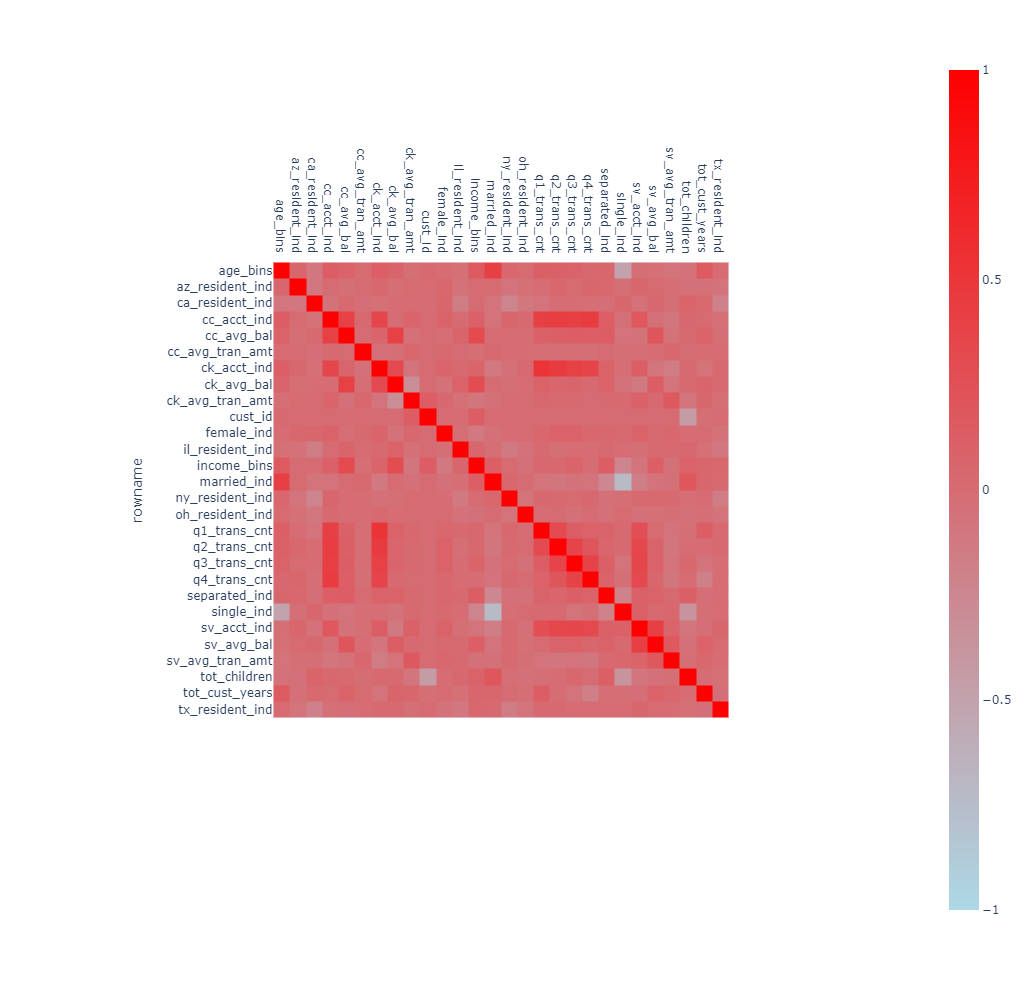

In [49]:
data = Cor_Mat.result.to_pandas().reset_index()
shaped_data = data.set_index("rowname").iloc[:,-len(data):].reindex(sorted(data.set_index("rowname").iloc[:,-len(data):]), axis=0).reindex(sorted(data.set_index("rowname").iloc[:,-len(data):]), axis=1)

fig = px.imshow(shaped_data, 
                x=shaped_data.index, 
                y=shaped_data.columns,
                color_continuous_scale=["lightblue","red"], 
                zmin=-1,
                zmax=1,
                height=1000,
               )

#z= [[np.round(float(i), 2) for i in nested] for nested in z]
fig.update_xaxes(side="top")          
fig.show()

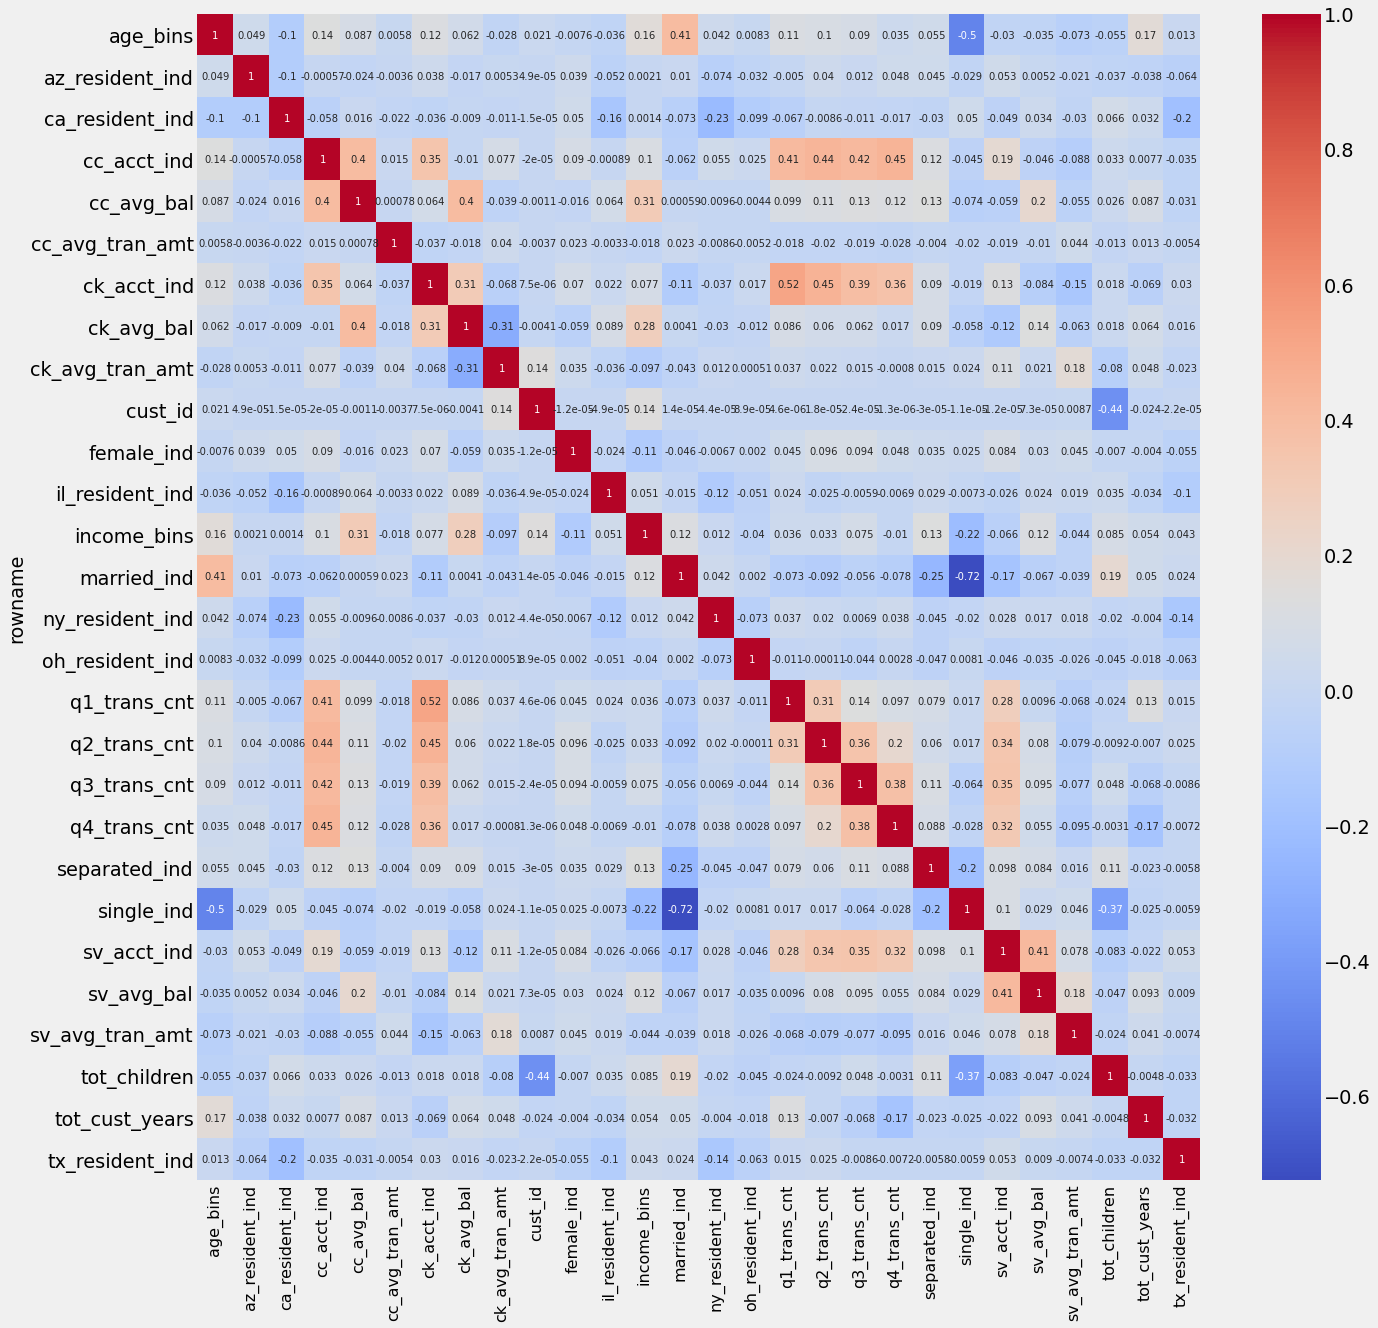

In [51]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
p = sns.heatmap(shaped_data, cmap='coolwarm', annot=True, annot_kws={'size':10})

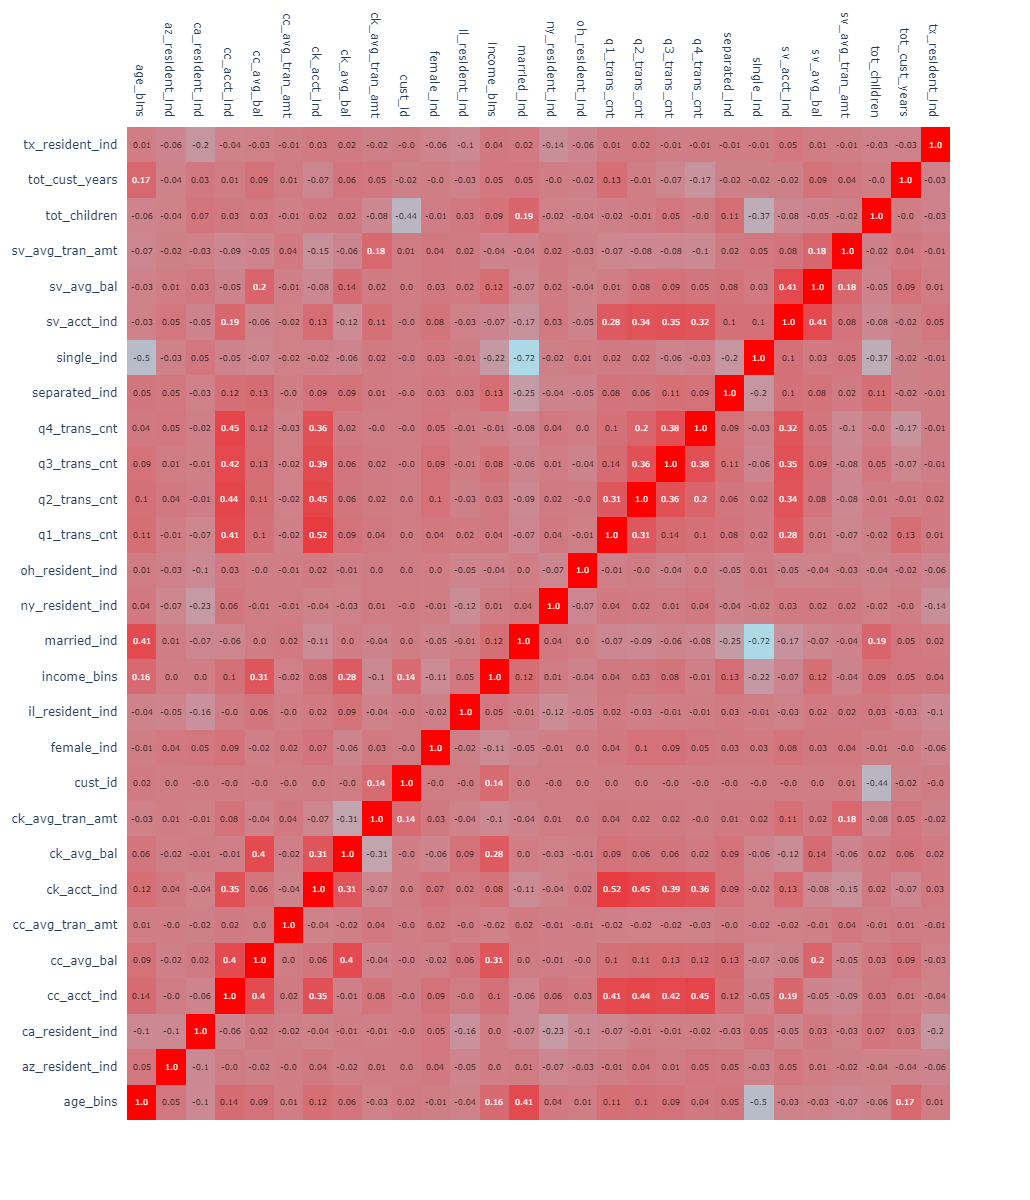

In [52]:
plt.rcParams['figure.figsize'] = (25, 10)

z = shaped_data.values
x=list(shaped_data.index)
y=list(shaped_data.columns)
z_text = [[np.round(float(i), 2) for i in nested] for nested in z]
colorscale = [[0,'lightblue'], [1, 'red']]
font_colors = ['black','white']


fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale=colorscale, font_colors=font_colors)

# Make text size smaller
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 8

fig['layout'].update(
    width=1050,
    height=1200,
    autosize=False
)
fig.show()

In [53]:
Cor_Mat = valib.Matrix(data=ADS_Py, columns='all', exclude_columns="cust_id", group_columns = "state_code", type="COR")

# Print the results.
Cor_Mat.result.to_pandas().head(30)

income_bins  age_bins  \
state_code         rownum rowname                                  
OTHER              5      female_ind         -0.086347 -0.023061   
                   21     ck_avg_tran_amt    -0.114280 -0.046158   
NY                 24     q1_trans_cnt        0.023033  0.176344   
OTHER              23     cc_avg_tran_amt    -0.024498  0.002905   
OH                 17     cc_acct_ind         0.342201  0.314006   
TX                 20     cc_avg_bal          0.229288  0.065093   
OH                 25     q2_trans_cnt        0.190227  0.310297   
                   14     oh_resident_ind     1.000000  1.000000   
OTHER              1      income_bins         1.000000  0.136156   
                   9      ca_resident_ind     1.000000  1.000000   
CA                 18     ck_avg_bal          0.228436  0.132500   
TX                 13     az_resident_ind     1.000000  1.000000   
AZ                 15     ck_acct_ind        -0.108314  0.079930   
CA                 6      single_ind         -0.298617 -0.501431   
OH                 21     ck_avg_tran_amt     0.063488  0.036064   
NY                 6      single_ind         -0.153939 -0.469176   
                   8      separated_ind      -0.012612  0.093594   
                   1      income_bins         1.000000  0.033200   
CA                 14     oh_resident_ind     1.000000  1.000000   
OTHER              12     il_resident_ind     1.000000  1.000000   
TX                 12     il_resident_ind     1.000000  1.000000   
                   27     q4_trans_cnt        0.025409 -0.055067   
                   3      tot_cust_years      0.155620  0.328721   
AZ                 27     q4_trans_cnt       -0.099457  0.323881   
                   4      tot_children        0.029047 -0.274605   
NY                 4      tot_children        0.087573 -0.144868   
OTHER              15     ck_acct_ind         0.082954  0.122901   
AZ                 26     q3_trans_cnt       -0.045415  0.150472   
TX                 16     sv_acct_ind        -0.055509 -0.004955   
OH                 4      tot_children       -0.026521 -0.062469   

                                           tot_cust_years  tot_children  \
state_code         rownum rowname                                         
OTHER              5      female_ind            -0.007455     -0.038464   
                   21     ck_avg_tran_amt        0.069804     -0.101932   
NY                 24     q1_trans_cnt           0.195745     -0.025597   
OTHER              23     cc_avg_tran_amt        0.003754     -0.014622   
OH                 17     cc_acct_ind            0.237191      0.034584   
TX                 20     cc_avg_bal             0.055172      0.032630   
OH                 25     q2_trans_cnt           0.224562     -0.079368   
                   14     oh_resident_ind        1.000000      1.000000   
OTHER              1      income_bins            0.032748      0.104305   
                   9      ca_resident_ind        1.000000      1.000000   
CA                 18     ck_avg_bal             0.109713     -0.040959   
TX                 13     az_resident_ind        1.000000      1.000000   
AZ                 15     ck_acct_ind            0.108723      0.006981   
CA                 6      single_ind             0.000869     -0.464425   
OH                 21     ck_avg_tran_amt        0.099643     -0.137459   
NY                 6      single_ind            -0.093347     -0.333613   
                   8      separated_ind         -0.026239      0.049801   
                   1      income_bins            0.115248      0.087573   
CA                 14     oh_resident_ind        1.000000      1.000000   
OTHER              12     il_resident_ind        1.000000      1.000000   
TX                 12     il_resident_ind        1.000000      1.000000   
                   27     q4_trans_cnt          -0.173238      0.029264   
                   3      tot_cust_years         1.000000      0.0

# Logistic Regression 

## LogReg() Function:

### SIGNATURE:
> valib.LogReg(data, matrix_data=None, columns=None, response_column=None, backward=None, backward_only=None, exclude_columns=None, cond_ind_threshold=30, constant=True, convergence=0.001, entrance_criterion=0.05, forward=None, forward_only=None, group_columns=None, lift_output=None, max_iter=100, mem_size=None, near_dep_report=None, remove_criterion=0.05, response_value=None, sample=None, stats_output=False, stepwise=False, success_output=False, start_threshold=None, end_threshold=None, increment_threshold=None, threshold_output=False, variance_prop_threshold=0.5)

### DESCRIPTION:
Logistic Regression is one of the most widely used types of statistical analysis. In Logistic Regression, a set of independent variables (in this case, columns) is processed to predict the value of a dependent variable (column) that assumes two values referred to as response (1) and non-response (0). The user can specify which value of the dependent variable to treat as the response, and all other values assumed by the dependent variable are treated as non-repsonse. The result is not, however, a continuous numeric variable as seen in Linear Regression, but rather a probability between 0 and 1 that the response value is assumed by the dependent variable.
There are many types of analysis that lend themselves to the use of Logistic Regression, and when scoring a model, benefit from the estimation of a probability rather than a fixed value. For example, when predicting who should be targeted for a marketing campaign, the scored customers can be ordered by the predicted probability from most to least likely, and the top n values taken from the customer list.
Some of the key features of Logistic Regression are outlined below.
- The Teradata table operator CALCMATRIX is used to build an ESSCP matrix for purposes of validating the input data, such as by checking for constant values. Also, to avoid rebuilding this matrix every time the algorithm is run, the user may run the Matrix Analysis separately, saving an ESSCP matrix in a teradataml DataFrame that can then be input to Logistic Regression. Refer "matrix_data" argument.
- One or more group by columns can optionally be specified so that an input matrix is built for each combination of group by column values, and subsequently a separate Logistic Regression model is built for each matrix. To achieve this, the names of the group by columns are passed to CALCMATRIX as parameters, so it includes them as columns in the matrix data it creates. Refer "group_columns" argument.
- The stepwise feature for Logistic Regression is a technique for selecting the independent variables in a logistic model. It consists of different methods of 'trying' variables and adding or removing them from a model through a series of forward and backward steps described in the parameter section. 
- A Statistics data is available, displaying the mean and standard deviation of each model variable. Refer to the "stats_output" argument.
- A Success data is available, displaying counts of predicted versus actual values of the dependent variable in the logistic model.
- A Multi-Threshold Success Table is available. Refer "threshold_output" argument.
- A Lift Table, such as would be used to build a Lift Chart, is available. Refer "lift_output" argument.
- A Near Dependency Report is available to identify two or more columns that may be collinear. 
- The algorithm is partially scalable because the size of each input matrix depends only on the number of independent variables (columns) and not on the size of the input data. The calculations performed on the client workstation however are not scalable when group by columns are used, because each model is built serially based on each matrix in the matrix data.

### PARAMETERS:

#### data:
Required Argument.
Specifies the input data to build a logistic regression model from.

Types: teradataml DataFrame

#### columns:
Required Argument.
Specifies the name(s) of the column(s) representing the independent variables used in building a logistic regression model. Occasionally, it can also accept permitted strings to specify all columns, or all numeric columns.
Permitted Values: 
- Name(s) of the column(s) in "data".
- Pre-defined strings: 
    - 'all' – all columns
    - 'allnumeric' – all numeric columns

Types: str OR list of Strings (str)

#### response_column:
Required Argument.
Specifies the name of the column that represents the dependent variable being predicted.

Types: str

#### backward:
Optional Argument.
Specifies whether to take backward steps or not. Backward steps, i.e., removing variables from a model, use the P-value of the T-statistic, i.e., the ratio of a B-coefficient to its standard error. The variable (column) with the largest P-value is removed if the P-value exceeds the criterion to remove.

Types: bool

#### backward_only:
Optional Argument.
Specifies whether to use only backward technique or not. This technique is similar to the backward technique, except that a forward step is not performed. It starts with all independent variables in the model. Backward steps are executed until no more are possible.

Types: bool

#### exclude_columns:
Optional Argument.
Specifies the name(s) of the column(s) to exclude from the analysis, if a column specifier such as 'all', 'allnumeric' is used in the "columns" argument. By default, when the "exclude_columns" argument is used, dependent variable and group by columns, if any, are automatically excluded as input columns and do not need to be included as "exclude_columns".

Types: str OR list of Strings (str)

#### cond_ind_threshold:
Optional Argument.
Specifies the condition index threshold value to use while generating near dependency report. This is used when "near_dep_report" is set to True.
Default Value: 30

Types: int

#### constant:
Optional Argument.
Specifies whether the logistic model includes a constant term or not. When set to True, model includes a constant term.
Default Value: True

Types: bool

#### convergence:
Optional Argument.
Specifies the convergence criterion such that the algorithm stops iterating when the change in log likelihood function falls below this value.
Default Value: 0.001

Types: float

#### entrance_criterion:
Optional Argument.
Specifies the criterion to enter a variable into the model. The W-statistic chi-square P-value must be less than this value for a variable to be added.
Default Value: 0.05

Types: float

#### forward:
Optional Argument.
Specifies whether to use forward technique or not. When set to True, in this technique, starting with no independent variables in the model, a forward step is performed, adding the "best" choice, followed by a backward step, removing the "worst" choice. Refer to the "stepwise" argument for a description of the steps in this technique.

Types: bool

#### forward_only:
Optional Argument.
Specifies whether to use only forward technique or not. This technique is similar to the forward technique, except that a backward step is not performed. 

Types: bool

#### group_columns:
Optional Argument.
Specifies the name(s) of the column(s) dividing the input into partitions, one for each combination of values in the group by columns. For each partition or combination of values a separate logistic model and XML report is built.

Types: str OR list of Strings (str)

#### lift_output:
Optional Argument.
Specifies whether to build a lift chart or not and add it in the functions output string. It splits up the computed probability values into deciles with the usual counts and percentages to demonstrate what happens when more and more rows of ordered probabilities are accumulated.

Types: bool

#### matrix_data:
Optional Argument.
Specifies the input matrix data to use for the analysis. Instead of internally building a matrix with the Matrix function each time this analysis is performed, the user may build an ESSCP Matrix once with the Matrix Analysis using Matrix() function. The matrix can subsequently be read from this data instead of re-building it each time. If this is specified, the columns specified with the "columns" argument should be a subset of the columns in this matrix and can be specified in any order. The columns must however all be present in the matrix. Further, if group by columns are specified in the matrix, these same group by columns must be specified in this analysis.

Types: teradataml DataFrame

#### max_iter:
Optional Argument.
Specifies The maximum number of attempts to converge on a solution.
Default Value: 100

Types: int

#### mem_size:
Optional Argument.
Specifies the memory size in megabytes to allocate for in-memory Logistic Regression. If there is too much data to fit in this amount of memory or is set to 0 or argument is not specified, normal SQL processing is performed. 

Types: int

#### near_dep_report:
Optional Argument.
Specifies whether to produce an XML report showing columns that may be collinear as part of the output or not. The report is included in the XML output only if collinearity is detected.
Two threshold arguments are available for this report, "cond_ind_threshold" and "variance_prop_threshold". 

Types: bool

#### remove_criterion:
Optional Argument.
Specifies the criterion to remove a variable from the model. The T-Statistic P-value must be greater than this value for a variable to be removed.
Default Value: 0.05

Types: float

#### response_value:
Optional Argument.
Specifies the value assumed by the dependent column that is to be treated as the response value.

Types: str

#### sample:
Optional Argument.
Specifies whether to use sample of the data to be read into memory for processing, if the memory size available is less than the amount of data to process. When set to True, a sample of data is read.

Types: bool

#### stats_output:
Optional Argument.
Specifies whether an optional data quality report should be delivered in the function's XML output string or not, which includes the mean and standard deviation of each model variable, derived from an ESSCP matrix.
Default Value: False

Types: bool

#### stepwise:
Optional Argument.
Specifies whether to perform a stepwise procedure or not. 
Forward steps, i.e., adding variables to a model, add the variable with the smallest chi-square P-value connected to its special W-statistic, provided the P-value is less than the criterion to enter. 
Backward steps, i.e., removing variables from a model, use the P-value of the T-statistic, i.e., the ratio of a B-coefficient to its standard error. The variable (column) with the largest P-value is removed if the P-value exceeds the criterion to remove.
Default Value: False

Types: bool

#### success_output:
Optional Argument.
Specifies whether an optional success report should be delivered in the function's XML output string or not, which includes the displaying counts of predicted versus actual values of the dependent variable of the logistic regression model. This report is similar to the Decision Tree Confusion Matrix, but the success report only includes two values of the dependent variable, namely response versus non-response.
Default Value: False

Types: bool

#### start_threshold:
Optional Argument.
Specifies the beginning threshold value utilized in the Multi-Threshold Success output.

Types: float, int

#### end_threshold:
Optional Argument.
Specifies the ending threshold value utilized in the Multi-Threshold Success output.

Types: float, int

#### increment_threshold:
Optional Argument.
Specifies the difference in threshold values between adjacent rows in the Multi-Threshold Success output.

Types: float, int

#### threshold_output:
Optional Argument.
Specifies whether the Multi-Threshold Success output should be produced or not and included in the XML output string in the result. This report can be thought of as a table where each row is a Prediction Success Table, and each row has a different threshold value as generated by the "start_threshold", "end_threshold", and "increment_threshold" arguments. What is meant by a threshold here is the value above which the predicted probability indicates a response.
Default Value: False

Types: bool

#### variance_prop_threshold:
Optional Argument.
Specifies the variance proportion threshold value to use while generating near dependency report. This is used when "near_dep_report" is set to True.
Default Value: 0.5

Types: float

### RETURNS:
An instance of LogReg.
Output teradataml DataFrames can be accessed using attribute references, such as LogRegObj.<attribute_name>.
Output teradataml DataFrame attribute names are:
1. model
2. statistical_measures
3. xml_reports

### RAISES:
TeradataMlException, TypeError, ValueError

In [58]:
# Parse out XML and produce readable reports

import xmltodict, json
from collections import OrderedDict
import pandas as pd

flatten_list = lambda t: [item for sublist in t for item in sublist]

def flatten_dict(d):
    """
    """
    result = OrderedDict()
    for k, v in d.items():
        if isinstance(v, dict):
            result.update(flatten_dict(v))
        else:
            result[k] = v
    return result

def logit_xml_to_pandas(xml_reports_string):
    """
    Input: 
        logreg output XML string 
    Output:
        pd.DataFrame
    """
    nested_dict = xmltodict.parse(xml_reports_string)
    flat_dict = flatten_dict(nested_dict)
    l = list()

    for i,_ in enumerate(flat_dict['ThresholdProbability']):
        d = flat_dict['ThresholdProbability'][i]
        flat_dict['ThresholdProbability'][i]['Case'] = pd.DataFrame(flat_dict['ThresholdProbability'][i]['Case'])
        flat_dict['ThresholdProbability'][i]['@probability'] = pd.DataFrame([flat_dict['ThresholdProbability'][i]['@probability'] for _ in range(len(d["Case"]))], columns = ['@probability'])
        inner_df = pd.concat(d, axis=1).sum(axis=1, level=1)
        flat_dict['ThresholdProbability'][i] = inner_df
        l.append(inner_df)
    
    df = pd.concat(l)
    df.reset_index(drop=True, inplace=True)
    df2 = pd.DataFrame(flat_dict, columns=flat_dict.keys())
    df3 = df2[df2.columns[:-1]]
    df4 = pd.concat([df3[:1]]*len(df), ignore_index=True)
    df5 = pd.concat([df4, df],axis=1)
    
    return df5

1.  Using the ADS_SQL table, lets build a logistic regression model to predict the customer bases propensity to open a credit card account (cc_acct_ind) based upon all non-credit card variables in the analytic data set.  The model coefficients and variable statistics are created within the model and statistical_measure objects.  The reports for the success table, threshold table and lift table are returned in an XML string within the xml_reports object.

In [59]:
Logit_Model = valib.LogReg(data=ADS_Py, 
                           columns='all', 
                           exclude_columns="cust_id, state_code, cc_avg_tran_amt, cc_avg_bal",
                           response_column="cc_acct_ind", 
                           response_value=1,
                           threshold_output='true',
                           near_dep_report='true', 
                           cond_ind_threshold=25,
                           variance_prop_threshold=0.5)

# Print the results using pandas for readability

In [60]:
Logit_Model.model.to_pandas().head(30)

B Coefficient  Standard Error  Wald Statistic  T Statistic  \
Column Name                                                                   
single_ind            0.802222        0.179436       19.987996     4.470794   
ny_resident_ind      -0.285206        0.143916        3.927326    -1.981748   
income_bins           0.035043        0.004612       57.738020     7.598554   
ca_resident_ind      -0.616516        0.114997       28.742066    -5.361163   
az_resident_ind      -1.099712        0.252951       18.901075    -4.347537   
q3_trans_cnt          0.037182        0.001574      558.039657    23.622863   
tot_children          0.091757        0.034352        7.134816     2.671108   
tx_resident_ind      -0.307696        0.151208        4.140891    -2.034918   
(Constant)           -0.010206        0.274499        0.001382    -0.037182   
ck_avg_bal           -0.000043        0.000012       13.390572    -3.659313   
age_bins              0.106736        0.024454       19.050982     4.364743   
ck_avg_tran_amt       0.006676        0.000926       51.939900     7.206934   
female_ind            0.031585        0.089059        0.125779     0.354653   
q2_trans_cnt          0.036306        0.001537      558.004948    23.622128   
separated_ind         1.704625        0.251997       45.757944     6.764462   
married_ind           0.355546        0.157996        5.064086     2.250352   
sv_avg_bal           -0.000124        0.000016       64.109310    -8.006829   
q1_trans_cnt          0.023858        0.000835      816.280374    28.570621   
ck_acct_ind          -6.186405        0.189094     1070.332954   -32.715943   
sv_acct_ind          -3.725782        0.140628      701.927965   -26.493923   
il_resident_ind       0.312812        0.165530        3.571216     1.889766   
tot_cust_years        0.055857        0.015846       12.426011     3.525055   
sv_avg_tran_amt       0.000208        0.000631        0.108643     0.329610   
oh_resident_ind       0.790995        0.281002        7.923734     2.814913   
q4_trans_cnt          0.052511        0.001660     1000.402228    31.629136   

                       P-Value  Odds Ratio     Lower     Upper  Partial R  \
Column Name                                                                 
single_ind        7.885610e-06    2.230491  1.569149  3.170566   0.039873   
ny_resident_ind   4.753692e-02    0.751859  0.567067  0.996870  -0.013052   
income_bins       3.286260e-14    1.035664  1.026345  1.045068   0.070188   
ca_resident_ind   8.467593e-08    0.539822  0.430888  0.676294  -0.048616   
az_resident_ind   1.391450e-05    0.332967  0.202810  0.546655  -0.038649   
q3_trans_cnt      0.000000e+00    1.037882  1.034685  1.041089   0.221686   
tot_children      7.573342e-03    1.096098  1.024730  1.172437   0.021303   
tx_resident_ind   4.188753e-02    0.735138  0.546588  0.988730  -0.013756   
(Constant)        9.703409e-01         NaN       NaN       NaN        NaN   
ck_avg_bal        2.542960e-04    0.999957  0.999934  0.999980  -0.031729   
age_bins          1.286519e-05    1.112640  1.060570  1.167267   0.038820   
ck_avg_tran_amt   6.170620e-13    1.006698  1.004872  1.008527   0.066437   
female_ind        7.228579e-01    1.032089  0.866782  1.228922   0.000000   
q2_trans_cnt      0.000000e+00    1.036973  1.033854  1.040101   0.221679   
separated_ind     1.418976e-11    5.499325  3.355900  9.011764   0.062189   
married_ind       2.444992e-02    1.426959  1.046949  1.944902   0.016456   
sv_avg_bal        1.318831e-15    0.999876  0.999845  0.999906  -0.074091   
q1_trans_cnt      0.000000e+00    1.024145  1.022470  1.025823   0.268270   
ck_acct_ind      2.859515e-222    0.002057  0.001420  0.002980  -0.307283   
sv_acct_ind      3.687545e-149    0.024094  0.018290  0.031741  -0.248721   
il_resident_ind   5.882040e-02    1.367265  0.988447  1.891261   0.011784   
tot_cust_years    4.254382e-04    1.057447  1.025110  1.090803   0.030356   
sv_avg_tran_amt   7.417021e-01    1

In [61]:
Logit_Model.statistical_measures.to_pandas().head(30)

Total Observations  Total Iterations  Initial Log Likelihood  \
rid                                                                 
1                9296.0               8.0             -5657.17719   

     Final Log Likelihood  Likelihood Ratio Test G Statistic  \
rid                                                            
1            -1810.653056                        7693.048268   

     Chi-Square Degrees of Freedom  Chi-Square Value  Chi-Square Probability  \
rid                                                                            
1                             24.0         36.415029                     0.0   

     McFaddens Pseudo R-Squared Dependent Variable  Dependent Response Value  \
rid                                                                            
1                      0.679937        cc_acct_ind                       1.0   

     Total Distinct Values  
rid                         
1                      2.0

In [62]:
xml_model_string = Logit_Model.xml_reports.to_pandas()["XmlModel"].loc[1]
logit_xml_to_pandas(xml_model_string)

Database Tablename IndependentVariables DependentVariable ResponseValue  \
0   RB255002    ADS_Py                   24       cc_acct_ind             1   
1   RB255002    ADS_Py                   24       cc_acct_ind             1   
2   RB255002    ADS_Py                   24       cc_acct_ind             1   
3   RB255002    ADS_Py                   24       cc_acct_ind             1   
4   RB255002    ADS_Py                   24       cc_acct_ind             1   
..       ...       ...                  ...               ...           ...   
75  RB255002    ADS_Py                   24       cc_acct_ind             1   
76  RB255002    ADS_Py                   24       cc_acct_ind             1   
77  RB255002    ADS_Py                   24       cc_acct_ind             1   
78  RB255002    ADS_Py                   24       cc_acct_ind             1   
79  RB255002    ADS_Py                   24       cc_acct_ind             1   

   Stepwise MemorySize Sample         Constant  @probability  \
0      none          0  false  IncludeConstant          0.00   
1      none          0  false  IncludeConstant          0.00   
2      none          0  false  IncludeConstant          0.00   
3      none          0  false  IncludeConstant          0.00   
4      none          0  false  IncludeConstant          0.05   
..      ...        ...    ...              ...           ...   
75     none          0  false  IncludeConstant          0.90   
76     none          0  false  IncludeConstant          0.95   
77     none          0  false  IncludeConstant          0.95   
78     none          0  false  IncludeConstant          0.95   
79     none          0  false  IncludeConstant          0.95   

                                       @Desc  @count  
0           Got response, estimated response  6552.0  
1       Got response, estimated non-response     0.0  
2       Got non-response, estimated response  2744.0  
3   Got non-response, estimated non-response     0.0  
4           Got response, estimated response  6505.0  
..                                       ...     ...  
75  Got non-response, estimated non-response  2679.0  
76          Got response, estimated response  5017.0  
77      Got response, estimated non-response  1535.0  
78      Got non-response, estimated response    36.0  
79  Got non-response, estimated non-response  2708.0  

[80 rows x 12 columns]

2.  Using the same table, lets build a logistic regression model to predict the customer bases propensity to open a credit card account (cc_acct_ind), by state,  based upon all non-credit card variables in the analytic data set.  This type of micro-modelling is done using the groupby option.  The model coefficients and variable statistics are created within the model and statistical_measure objects.  The reports for the success table, threshold table and lift table are returned in an XML string within the xml_reports object.

In [63]:
Logit_Model2 = valib.LogReg(data=ADS_Py, 
                            columns='all', 
                            exclude_columns="cust_id, az_resident_ind, il_resident_ind, oh_resident_ind, tx_resident_ind, ny_resident_ind, ca_resident_ind, cc_avg_tran_amt, cc_avg_bal",
                            response_column="cc_acct_ind", 
                            response_value=1,
                            threshold_output='true',
                            near_dep_report='true', 
                            cond_ind_threshold=25,
                            variance_prop_threshold=0.5,
                            group_columns="state_code")

# Print the results using pandas for readability

In [64]:
Logit_Model2.model.to_pandas().head(30)

Column Name  \
state_code                                                              
CA                                                         (Constant)   
OH                  ***Constant columns detected...run terminated.***   
OTHER                                                      (Constant)   
TX                                                         (Constant)   
AZ                                                         (Constant)   
NY                                                         (Constant)   
IL                                                         (Constant)   
CA                                                        income_bins   
OTHER                                                     income_bins   
TX                                                        income_bins   
AZ                                                        income_bins   
NY                                                        income_bins   
IL                                                        income_bins   
CA                                                           age_bins   
OTHER                                                        age_bins   
TX                                                           age_bins   
AZ                                                           age_bins   
NY                                                           age_bins   
IL                                                           age_bins   
CA                                                     tot_cust_years   
OTHER                                                  tot_cust_years   
TX                                                     tot_cust_years   
AZ                                                     tot_cust_years   
NY                                                     tot_cust_years   
IL                                                     tot_cust_years   
CA                                                       tot_children   
OTHER                                                    tot_children   
TX                                                       tot_children   
AZ                                                       tot_children   
NY                                                       tot_children   

                    B Coefficient  Standard Error  Wald Statistic  \
state_code                                                          
CA                       5.096692        1.424679       12.798012   
OH                            NaN             NaN             NaN   
OTHER                   -1.045952        0.434314        5.799825   
TX                      -1.636467        1.237917        1.747557   
AZ                       5.315593     1335.717371        0.000016   
NY                      16.854321        3.578191       22.186844   
IL                      -0.538685        1.357794        0.157399   
CA                       0.083575        0.017649       22.423574   
OTHER                    0.044420        0.008792       25.527609   
TX                       0.035747        0.013920        6.594530   
AZ                      -0.048339       16.391501        0.000009   
NY                       0.052368        0.047233        1.229229   
IL                       0.098557        0.022649       18.935333   
CA                       0.687585        0.108322       40.292075   
OTHER                    0.194932        0.038173       26.076660   
TX                      -0.144151        0.106349        1.837261   
AZ                       0.879683       94.187256        0.000087   
NY                      -3.883268        0.702623       30.545716   
IL                       0.116832        0.183597        0.404941   
CA                       0.014873        0.060417        0.060604   
OTHER                    0.113180        0.026146       18.738881   
TX                       0.362234        0.081484       19.762073   
AZ                      -0.082114       53.647230        0.000002

In [65]:
Logit_Model2.statistical_measures.to_pandas().head(30)

state_code  Total Observations  Total Iterations  \
rid                                                             
3    IL                               714.0              13.0   
7    TX                              1050.0               9.0   
5    OH                               322.0               NaN   
2    CA                              2226.0              11.0   
6    OTHER                           3388.0               9.0   
4    NY                              1344.0              14.0   
1    AZ                               308.0              14.0   

     Initial Log Likelihood  Final Log Likelihood  \
rid                                                 
3               -444.143078           -126.952690   
7               -686.089105           -137.647994   
5                       NaN                   NaN   
2              -1452.564665           -180.140678   
6              -1975.698007           -655.836860   
4               -723.431457            -50.454913   
1               -192.651339             -0.000559   

     Likelihood Ratio Test G Statistic  Chi-Square Degrees of Freedom  \
rid                                                                     
3                           634.380777                           18.0   
7                          1096.882220                           18.0   
5                                  NaN                            NaN   
2                          2544.847973                           18.0   
6                          2639.722294                           18.0   
4                          1345.953087                           18.0   
1                           385.301559                           18.0   

     Chi-Square Value  Chi-Square Probability  McFaddens Pseudo R-Squared  \
rid                                                                         
3           28.869299                     0.0                    0.714163   
7           28.869299                     0.0                    0.799373   
5                 NaN                     NaN                         NaN   
2           28.869299                     0.0                    0.875984   
6           28.869299                     0.0                    0.668048   
4           28.869299                     0.0                    0.930256   
1           28.869299                     0.0                    0.999997   

    Dependent Variable  Dependent Response Value  Total Distinct Values  
rid                                                                      
3          cc_acct_ind                       1.0                    2.0  
7          cc_acct_ind                       1.0                    2.0  
5                 None                       NaN                    NaN  
2          cc_acct_ind                       1.0                    2.0  
6          cc_acct_ind                       1.0                    2.0  
4          cc_acct_ind                       1.0                    2.0  
1          cc_acct_ind                       1.0                    2.0

In [66]:
# Show the Reports for CA
xml_model_string = Logit_Model2.xml_reports.to_pandas()["XmlModel"].loc['CA                ']
logit_xml_to_pandas(xml_model_string)

Database Tablename IndependentVariables DependentVariable ResponseValue  \
0   RB255002    ADS_Py                   18       cc_acct_ind             1   
1   RB255002    ADS_Py                   18       cc_acct_ind             1   
2   RB255002    ADS_Py                   18       cc_acct_ind             1   
3   RB255002    ADS_Py                   18       cc_acct_ind             1   
4   RB255002    ADS_Py                   18       cc_acct_ind             1   
..       ...       ...                  ...               ...           ...   
75  RB255002    ADS_Py                   18       cc_acct_ind             1   
76  RB255002    ADS_Py                   18       cc_acct_ind             1   
77  RB255002    ADS_Py                   18       cc_acct_ind             1   
78  RB255002    ADS_Py                   18       cc_acct_ind             1   
79  RB255002    ADS_Py                   18       cc_acct_ind             1   

   Stepwise MemorySize Sample         Constant       @name  @value  \
0      none          0  false  IncludeConstant  state_code  CA       
1      none          0  false  IncludeConstant  state_code  CA       
2      none          0  false  IncludeConstant  state_code  CA       
3      none          0  false  IncludeConstant  state_code  CA       
4      none          0  false  IncludeConstant  state_code  CA       
..      ...        ...    ...              ...         ...     ...   
75     none          0  false  IncludeConstant  state_code  CA       
76     none          0  false  IncludeConstant  state_code  CA       
77     none          0  false  IncludeConstant  state_code  CA       
78     none          0  false  IncludeConstant  state_code  CA       
79     none          0  false  IncludeConstant  state_code  CA       

    @probability                                     @Desc  @count  
0           0.00          Got response, estimated response  6552.0  
1           0.00      Got response, estimated non-response     0.0  
2           0.00      Got non-response, estimated response  2744.0  
3           0.00  Got non-response, estimated non-response     0.0  
4           0.05          Got response, estimated response  6277.0  
..           ...                                       ...     ...  
75          0.90  Got non-response, estimated non-response  2572.0  
76          0.95          Got response, estimated response  5850.0  
77          0.95      Got response, estimated non-response   702.0  
78          0.95      Got non-response, estimated response   143.0  
79          0.95  Got non-response, estimated non-response  2601.0  

[80 rows x 14 columns]

# Logistic Regression Evaluation

## LogRegEvaluator() Function:

### SIGNATURE:
>valib.LogRegEvaluator(data, model, estimate_column=None, index_columns=None, prob_column=None, accumulate=None, prob_threshold=0.5, start_threshold=None, end_threshold=None, increment_threshold=None)

### DESCRIPTION:
Logistic Regression function model can be passed to this function to generate evaluation reports. Function produces the result containing the following reports in XML format:
- Success result – This output is delivered in the function's XML output string, displaying counts of predicted versus actual values of the dependent variable of the logistic regression model. This report is similar to the Decision Tree Confusion Matrix, but the Success output only includes two values of the dependent variable, namely response versus non-response.
- Multi-Threshold Success result - This output is delivered in the function's XML output string. Report can be thought of as a table where each row is a Prediction Success Output, and each row has a different threshold value as generated by the "start_threshold", "end_threshold", and "increment_threshold" arguments. What is meant by a threshold here is the value above which the predicted probability indicates a response.
- Lift result – Result containing information, such as would be required to build a lift chart is available. It splits up the computed probability values into deciles with the usual counts and percentages to demonstrate what happens when more and more rows of ordered probabilities are accumulated. It is delivered in the function's XML output string.

### PARAMETERS:

#### data:
Required Argument.
Specifies the input data to evaluate.

Types: teradataml DataFrame

#### model:
Required Argument.
Specifies the input containing the logistic model to use in scoring. This must be the "model" teradataml DataFrame generated by LogReg() function from VALIB or a teradataml DataFrame created on a table generated by 'logistic' function from Vantage Analytic Library.

Types: teradataml DataFrame

#### estimate_column:
Required Argument.
Specifies the name of a column in the score output containing the estimated value of the dependent variable (column).
Notes:
    1. Either "estimate_column" or "prob_column" must be requested.
    2. If the estimate column is not unique in the score output, '_tm_' is automatically placed in front of the name.

Types: str

#### index_columns:
Optional Argument.
Specifies the name(s) of the column(s) representing the primary index of the score output. By default, the primary index columns of the score output are the primary index columns of the input. In addition, the index columns need to form a unique key for the score output. Otherwise, there are more than one score for a given observation.

Types: str OR list of Strings (str)

#### prob_column:
Optional Argument.
Specifies the name of a column in the score output containing the probability that the dependent value is equal to the response value.
Notes:
    1. Either "estimate_column" or "prob_column" must be requested.
    2. If the probability column is not unique in the score output, '_tm_' is automatically placed in front of the name.

Types: str

#### accumulate:
Optional Argument.
Specifies the name(s) of the column(s) from the input to retain in the output. 

Types: str OR list of Strings (str)

#### prob_threshold:
Optional Argument.
Specifies the probability threshold value. When the probability of the dependent variable being 1 is greater than or equal to this value, the estimated value of the dependent variable is 1. If less than this value, the estimated value is 0.
Default Value: 0.5

Types: float, int

#### start_threshold:
Optional Argument.
Specifies the beginning threshold value utilized in the Multi-Threshold Success output.

Types: float, int

#### end_threshold:
Optional Argument.
Specifies the ending threshold value utilized in the Multi-Threshold Success output.

Types: float, int

#### increment_threshold:
Optional Argument.
Specifies the difference in threshold values between adjacent rows in the Multi-Threshold Success output.

Types: float, int

### RETURNS:
An instance of LogRegEvaluator.
Output teradataml DataFrames can be accessed using attribute references, such as LogRegEvaluatorObj.<attribute_name>.
Output teradataml DataFrame attribute name is: result

### RAISES:
TeradataMlException, TypeError, ValueError

In [67]:
# XML Parsing code for reports

def parse_MTSS(MTSS_dict: OrderedDict):
    """
    """
    l = list()
    for i,_ in enumerate(MTSS_dict['ThresholdProbability']):
        d = MTSS_dict['ThresholdProbability'][i]
        MTSS_dict['ThresholdProbability'][i]['Case'] = pd.DataFrame(MTSS_dict['ThresholdProbability'][i]['Case'])
        MTSS_dict['ThresholdProbability'][i]['@probability'] = pd.DataFrame([MTSS_dict['ThresholdProbability'][i]['@probability'] for _ in range(len(d["Case"]))], columns = ['@probability'])
        inner_df = pd.concat(d, axis=1).sum(axis=1, level=1)
        MTSS_dict['ThresholdProbability'][i] = inner_df
        l.append(inner_df)
    df = pd.concat(l)
    return df

def parse_LT(LT_dict):
    """
    """
    l = list()
    for i,_ in enumerate(LT_dict['Decile']):
        d = LT_dict['Decile'][i]
        LT_dict['Decile'][i]['@Number'] = pd.DataFrame([LT_dict['Decile'][i]['@Number']], columns = ['@Number'])
        LT_dict['Decile'][i]['Measure'] = pd.DataFrame(LT_dict['Decile'][i]['Measure'])
        inner_df = pd.concat(d, axis=1)
        LT_dict['Decile'][i] = inner_df.sum(axis=1, level=1).max()
        l.append(inner_df.sum(axis=1, level=1).max().to_frame().T)
    df = pd.concat(l)
    return df

def logit_eval_xml_to_pandas(eval_string):
    """
    """
    nested_dict = xmltodict.parse(eval_string)
    MTSS_dict = nested_dict['LogisticRegression']['Model']['MultiThresholdSuccessTable']
    ST_dict = nested_dict['LogisticRegression']['Model']['SuccessTable']
    MTSD_dict = nested_dict['LogisticRegression']['Model']['MultiThresholdSuccessDisplay']
    LT_dict = nested_dict['LogisticRegression']['Model']['LiftTable']
    LD_dict = nested_dict['LogisticRegression']['Model']['LiftDisplay']
    MTSS_DF = parse_MTSS(MTSS_dict)
    ST_DF = pd.DataFrame(ST_dict['Case'])
    MTSD_DF = pd.DataFrame(MTSD_dict)
    LT_DF = parse_LT(LT_dict)
    LD_DF = pd.DataFrame(LD_dict)
    frames = dict(
              MultiThresholdSuccessTable=MTSS_DF,
              SuccessTable=ST_DF,
              MultiThresholdSuccessDisplay=MTSD_DF,
              LiftDisplay=LD_DF,
              LiftTable=LT_DF
             )
    return pd.concat(frames)

3. Evaluate the logistic regression model

In [68]:
Logit_Model_Eval = valib.LogRegEvaluator(data=ADS_Py, 
                                         model=Logit_Model.model, 
                                         index_columns="cust_id",
                                         prob_column="Probability")
 
# Print the results using pandas for readability

In [69]:
xml_eval_string = Logit_Model_Eval.result.to_pandas()['XmlModel'][1][54:]
full_df = logit_eval_xml_to_pandas(xml_eval_string)

In [70]:
# Lift Table 
full_df.loc['LiftTable'].dropna(axis=1)

@Number  @Count  @Response  @ResponsePct  @CapRespPct  @Lift  @CumResp  \
0      1.0   929.0      929.0        100.00        14.18   1.42     929.0   
0      2.0   930.0      930.0        100.00        14.19   1.42    1859.0   
0      3.0   929.0      929.0        100.00        14.18   1.42    2788.0   
0      4.0   930.0      927.0         99.68        14.15   1.41    3715.0   
0      5.0   930.0      908.0         97.63        13.86   1.39    4623.0   
0      6.0   929.0      889.0         95.69        13.57   1.36    5512.0   
0      7.0   930.0      648.0         69.68         9.89   0.99    6160.0   
0      8.0   929.0      261.0         28.09         3.98   0.40    6421.0   
0      9.0   930.0       61.0          6.56         0.93   0.09    6482.0   
0     10.0   930.0       70.0          7.53         1.07   0.11    6552.0   

   @CumRespPct  @CumCapRespPct  @CumLift  
0       100.00           14.18      1.42  
0       100.00           28.37      1.42  
0       100.00           42.55      1.42  
0        99.92           56.70      1.42  
0        99.46           70.56      1.41  
0        98.83           84.13      1.40  
0        94.67           94.02      1.34  
0        86.35           98.00      1.23  
0        77.48           98.93      1.10  
0        70.48          100.00      1.00

In [71]:
# Multithreshold Success Table
full_df.loc['MultiThresholdSuccessTable'].dropna(axis=1)

@probability                                     @Desc @count
0           0.00          Got response, estimated response   6552
1           0.00      Got response, estimated non-response      0
2           0.00      Got non-response, estimated response   2744
3           0.00  Got non-response, estimated non-response      0
0           0.05          Got response, estimated response   6505
..           ...                                       ...    ...
3           0.90  Got non-response, estimated non-response   2679
0           0.95          Got response, estimated response   5017
1           0.95      Got response, estimated non-response   1535
2           0.95      Got non-response, estimated response     36
3           0.95  Got non-response, estimated non-response   2708

[80 rows x 3 columns]

In [72]:
# Success Table
full_df.loc['SuccessTable'].dropna(axis=1)

@Desc   @count @Percent
0          Got response, estimated response  6017.63   64.73%
1      Got response, estimated non-response   534.37    5.75%
2                        Total got response  6552.00   70.48%
3      Got non-response, estimated response   534.37    5.75%
4  Got non-response, estimated non-response  2209.63   23.77%
5                        Total non-response  2744.00   29.52%
6                        Total observations  9296.00   100.0%

# Logistic Regression Scoring

## LogRegPredict() Function:

### SIGNATURE:
> valib.LogRegPredict(data, model, estimate_column=None, index_columns=None, prob_column=None, accumulate=None, prob_threshold=0.5)

### DESCRIPTION:
Logistic Regression function model can be passed to a Logistic Regression Scoring function to create a score output containing predicted values of the dependent variable. 

### PARAMETERS:

#### data:
Required Argument.
Specifies the input data to score.

Types: teradataml DataFrame

#### model:
Required Argument.
Specifies the input containing the logistic model to use in scoring. This must be the "model" teradataml DataFrame generated by LogReg() function from VALIB or a teradataml DataFrame created on a table generated by 'logistic' function from Vantage Analytic Library.

Types: teradataml DataFrame

#### estimate_column:
Required Argument.
Specifies the name of a column in the score output containing the estimated value of the dependent variable (column).
Notes:
    1. Either "estimate_column" or "prob_column" must be requested.
    2. If the estimate column is not unique in the score output, '_tm_' is automatically placed in front of the name.

Types: str

#### index_columns:
Optional Argument.
Specifies the name(s) of the column(s) representing the primary index of the score output. By default, the primary index columns of the score output are the primary index columns of the input. In addition, the index columns need to form a unique key for the score output. Otherwise, there are more than one score for a given observation.

Types: str OR list of Strings (str)

#### prob_column:
Optional Argument.
Specifies the name of a column in the score output containing the probability that the dependent value is equal to the response value.
Notes:
    1. Either "estimate_column" or "prob_column" must be requested.
    2. If the probability column is not unique in the score output, '_tm_' is automatically placed in front of the name.

Types: str

#### accumulate:
Optional Argument.
Specifies the name(s) of the column(s) from the input to retain in the output. 

Types: str OR list of Strings (str)

#### prob_threshold:
Optional Argument.
Specifies the probability threshold value. When the probability of the dependent variable being 1 is greater than or equal to this value, the estimated value of the dependent variable is 1. If less than this value, the estimated value is 0.
Default Value: 0.5
Types: float, int

### RETURNS:
An instance of LogRegPredict.
Output teradataml DataFrames can be accessed using attribute references, such as LogRegPredictObj.<attribute_name>.
Output teradataml DataFrame attribute name is: result

### RAISES:
TeradataMlException, TypeError, ValueError

4. Score the Logistic Regression Models

In [71]:
Logit_Model_Score = valib.LogRegPredict(data=ADS_Py, 
                                        model=Logit_Model.model, 
                                        index_columns="cust_id",
                                        estimate_column="cc_acct_ind",
                                        prob_column="Probability")
 
# Print the results using pandas for readability

Logit_Model_Score.result.to_pandas().head(30)

Probability  cc_acct_ind
cust_id                           
28617834     0.997675          1.0
21803664     0.104236          0.0
31346907     0.945661          1.0
25897836     0.966110          1.0
27258100     0.999918          1.0
13633310     0.999680          1.0
19085542     0.999970          1.0
28623294     0.089074          0.0
13625520     0.997779          1.0
31352657     0.765395          1.0
29984416     0.998595          1.0
19086522     0.995799          1.0
28627536     0.999686          1.0
25899527     0.261315          0.0
23178038     0.999937          1.0
31358062     0.798397          1.0
29996692     0.985012          1.0
29976386     0.964480          1.0
28626297     0.280257          0.0
28617792     0.988261          1.0
28629111     1.000000          1.0
14987885     0.985510          1.0
16352820     0.999983          1.0
16352412     0.262391          0.0
28624764     0.982952          1.0
17723810     0.805417          1.0
20444685     0.128574          0.0
17715204     0.999006          1.0
27263280     0.999993          1.0
21814960     0.990204          1.0

In [72]:
Logit_Model_Score2 = valib.LogRegPredict(data=ADS_Py, 
                                         model=Logit_Model2.model, 
                                         index_columns="cust_id",
                                         estimate_column="cc_acct_ind",
                                         prob_column="Probability")
 
# Print the results using pandas for readability

Logit_Model_Score2.result.to_pandas().head(30)

state_code   Probability  cc_acct_ind
cust_id                                                
28617834  CA                  1.000000e+00          1.0
21803664  NY                  5.318022e-02          0.0
31346907  IL                  9.999999e-01          1.0
25897836  OTHER               9.658966e-01          1.0
27258100  CA                  1.000000e+00          1.0
13633310  OTHER               9.991687e-01          1.0
19085542  IL                  9.999331e-01          1.0
28623294  NY                  5.117648e-11          0.0
13625520  CA                  9.998416e-01          1.0
31352657  OTHER               7.600511e-01          1.0
29984416  NY                  1.000000e+00          1.0
19086522  OTHER               9.977306e-01          1.0
28627536  NY                  1.000000e+00          1.0
25899527  OTHER               3.794949e-01          0.0
14987555  CA                  1.103803e-01          0.0
31358062  CA                  9.952635e-01          1.0
29996692  OTHER               9.881450e-01          1.0
29976386  IL                  9.680107e-01          1.0
28626297  TX                  1.712150e-02          0.0
28617792  CA                  9.999982e-01          1.0
28629111  TX                  1.000000e+00          1.0
14987885  NY                  1.000000e+00          1.0
16352820  OTHER               9.999999e-01          1.0
16352412  CA                  9.606196e-02          0.0
28624764  OTHER               9.996391e-01          1.0
17723810  NY                  1.000000e+00          1.0
20444685  IL                  1.154314e-02          0.0
17715204  NY                  1.000000e+00          1.0
27263280  NY                  1.000000e+00          1.0
21814960  OTHER               9.796278e-01          1.0

## End of session

In [73]:
# Remove the context of present teradataml session and terminate the Python session.
# It is recommended to call the remove_context() function for session cleanup.
# Temporary objects are removed at the end of the session.
#from teradataml import remove_context
#remove_context()